# Import packages and get authenticated

In [84]:
# from google.colab import drive
# drive.mount('drive')

In [18]:
import numpy as np
import pprint

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')
# sys.path.append('~/project_FDDAT/repo/')
sys.path.append('../') # add this line so Data and data are visible in this file
from os.path import expanduser
home = expanduser("~")

from falldetect.utilities import *
from falldetect.models import *
from falldetect.dataset_util import *
from falldetect.training_util import *
from falldetect.eval_util import *

import time
import datetime
from datetime import datetime
import json
import argparse

# Plotting
# checklist 1: comment inline, uncomment Agg
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Get user inputs
In ipython notebook, these are hardcoded. In production python code, use parsers to provide these inputs

In [10]:
parser = argparse.ArgumentParser(description='FD_DAT')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--extractor_type', metavar='extractor_type', help='extractor_type',
                    default='CNN')
parser.add_argument('--num_epochs', type=int, metavar='num_epochs', help='number of epochs',
                    default='5')
parser.add_argument('--CV_n', type=int, metavar='CV_n', help='CV folds',
                    default='2')
parser.add_argument('--rep_n', type=int, metavar='rep_n', help='number of repitition',
                    default='5')
parser.add_argument('--cuda_i', type=int, metavar='cuda_i', help='cuda index',
                    default='1')
parser.add_argument('--tasks_list', metavar='tasks_list', help='a list of all tasks',
                    default='UMAFall_waist_UPFall_belt UPFall_wrist_UMAFall_ankle')
parser.add_argument('--show_diagnosis_plt', metavar='show_diagnosis_plt', help='show diagnosis plt or not',
                    default='False')




# split_mode = 'LOO'
# split_mode = '5fold'

# checklist 2: comment first line, uncomment second line seizures_FN
args = parser.parse_args(['--input_folder', '../../data_mic/stage1_preprocessed_WithoutNormal_18hz_5fold', 
                          '--output_folder', '../../data_mic/stage2_modeloutput_WithoutNormal_18hz_5fold',
                          '--extractor_type', 'CNN',
                          '--num_epochs', '5',
#                           '--CV_n', '2',
#                           '--rep_n', '2',
#                           '--cuda_i', '2',
                          '--show_diagnosis_plt', 'True',
                          '--tasks_list', 'UPFall_wrist-UMAFall_wrist',])
#                           '--tasks_list', 'UMAFall_waist-UMAFall_wrist UPFall_wrist-UMAFall_ankle',])
                          
# args = parser.parse_args()

In [11]:
home_dir = home+'/project_FDDAT/'
input_folder = args.input_folder
output_folder = args.output_folder
extractor_type = args.extractor_type
num_epochs = args.num_epochs
CV_n = args.CV_n
rep_n = args.rep_n
show_diagnosis_plt = bool(args.show_diagnosis_plt)

with open('../../repo/falldetect/params.json') as json_file:
    falldetect_params = json.load(json_file)
cuda_i = falldetect_params['cuda_i']

tasks_list = []
for item in args.tasks_list.split(' '):
    tasks_list.append((item.split('-')[0], item.split('-')[1]))
    
inputdir = input_folder+'/'
outputdir = output_folder+'/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
test_mode = 'test' in outputdir.split('/')[-2]

device = torch.device('cuda:{}'.format(int(cuda_i)) if torch.cuda.is_available() else 'cpu')


In [12]:
training_params = {
    'HP_name': 'hp',
    'classes_n': 2,
    'CV_n': CV_n,
    'num_epochs': num_epochs,
    'channel_n': 4,
    'batch_size': 4,
    'learning_rate': 0.0001,
    'extractor_type': extractor_type,
    'device': device,
    'dropout': 0.5,
    'hiddenDim_f': 3,
    'hiddenDim_y': 3,
    'hiddenDim_d': 3,
    'win_size': 18,
    'win_stride': 6,
    'step_n': 9,
    'show_diagnosis_plt': show_diagnosis_plt,
  }

In [37]:

# # Convolutional neural network (two convolutional layers)
# class FeatureExtractor(nn.Module):
#   def __init__(self, input_dim=50, channel_n=16):
#       super(FeatureExtractor, self).__init__()
#       self.layer1 = nn.Sequential(
#           nn.Conv1d(3, channel_n, kernel_size=3, stride=1, padding=2),
#           nn.BatchNorm1d(channel_n),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=2, stride=2))
#       self.layer2 = nn.Sequential(
#           nn.Conv1d(channel_n, channel_n*2, kernel_size=3, stride=1, padding=2),
#           nn.BatchNorm1d(channel_n*2),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=2, stride=2))
#       self.layer3 = nn.Sequential(
#           nn.Conv1d(channel_n*2, channel_n*4, kernel_size=3, stride=1, padding=2),
#           nn.BatchNorm1d(channel_n*4),
#           nn.ReLU(),
#           nn.MaxPool1d(kernel_size=2, stride=2))
      
#       cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
#       pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

#       cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#       pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1
        
#       cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
#       pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1

# #       self.feature_out_dim = pool_layer2_dim*channel_n*2
#       self.feature_out_dim = pool_layer3_dim*channel_n*2
#       pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
#       print('FeatureExtractor_total_params:', pytorch_total_params)
      
#   def forward(self, x):
#     out1 = self.layer1(x.float())
#     out2 = self.layer2(out1)
#     out2 = self.layer3(out2)
#     out2 = out2.reshape(out2.size(0), -1)
#     return out2


# HIDDEN_DIM = 50
# # fall classifier neural network (fc layers)
# class ClassClassifier(nn.Module):
#   def __init__(self, num_classes=10, input_dim=50):
#       super(ClassClassifier, self).__init__()
#       self.fc1 = nn.Linear(input_dim, HIDDEN_DIM)
#       self.fc2 = nn.Linear(HIDDEN_DIM, num_classes)
#       self.drop = nn.Dropout(p=0.5)
#       self.relu = nn.ReLU()
    
#   def forward(self, x):
# #     out1 = self.drop(self.relu(self.fc1(x.float())))
#     out1 = self.relu(self.fc1(x.float()))
#     out2 = self.fc2(out1)
#     return out2

# # domain classifier neural network (fc layers)
# class DomainClassifier(nn.Module):
#   def __init__(self, num_classes=10, input_dim=50):
#       super(DomainClassifier, self).__init__()
# #       self.fc = nn.Linear(input_dim, num_classes)
#       self.fc1 = nn.Linear(input_dim, HIDDEN_DIM)
#       self.fc2 = nn.Linear(HIDDEN_DIM, num_classes)
#       self.drop = nn.Dropout(p=0.5)
#       self.relu = nn.ReLU()
      
#   def forward(self, x, constant):
#     out1 = GradReverse.grad_reverse(x.float(), constant)
# #     out1 = self.drop(self.relu(self.fc1(out1)))
#     out1 = self.relu(self.fc1(out1))
#     out2 = self.fc2(out1)
#     return out2
#     # out2 = F.relu(self.fc(out1))
# #     out2 = self.fc(out1)
# #     return out2


# class DannModel2(nn.Module):
#   def __init__(self, device, class_N=2, domain_N=2, channel_n=16, input_dim=10):
#     super(DannModel2, self).__init__()
#     self.feature_extractor = FeatureExtractor(input_dim=input_dim, channel_n=channel_n).to(device).float()
#     cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
#     pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

#     cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#     pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

#     cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
#     pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1
    
#     feature_out_dim = int(pool_layer3_dim*channel_n*4)
# #     feature_out_dim = int(pool_layer2_dim*channel_n*2)
#     self.class_classfier = ClassClassifier(num_classes=class_N, input_dim=feature_out_dim).to(device).float()
#     self.domain_classifier = DomainClassifier(num_classes=domain_N, input_dim=feature_out_dim).to(device).float()

#     pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
#     print('DannModel_total_params:', pytorch_total_params)
    

#   def forward(self, x):
#     feature_out = self.feature_extractor(x)
#     class_output = self.class_classfier(feature_out)
#     domain_output = self.domain_classifier(feature_out, 1)
#     return feature_out, class_output, domain_output

In [108]:
import math
math.floor(0.5)

0

In [121]:
KERNEL_SIZE = 7

# Convolutional neural network (two convolutional layers)
class FeatureExtractor(nn.Module):
  def __init__(self, input_dim=50, channel_n=16):
      super(FeatureExtractor, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv1d(3, channel_n, kernel_size=KERNEL_SIZE, stride=1, padding=2),
          nn.BatchNorm1d(channel_n),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv1d(channel_n, channel_n*2, kernel_size=KERNEL_SIZE, stride=1, padding=2),
          nn.BatchNorm1d(channel_n*2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      
      cnn_layer1_dim = (input_dim+2*2-1*(KERNEL_SIZE-1)-1)+1
      pool_layer1_dim = math.floor((cnn_layer1_dim-1*(2-1)-1)/2+1)

      cnn_layer2_dim = (pool_layer1_dim+2*2-1*(KERNEL_SIZE-1)-1)+1
      pool_layer2_dim = math.floor((cnn_layer2_dim-1*(2-1)-1)/2+1)

      self.feature_out_dim = pool_layer2_dim*channel_n*2
      pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print('FeatureExtractor_total_params:', pytorch_total_params)
      
  def forward(self, x):
    out1 = self.layer1(x.float())
    out2 = self.layer2(out1)
    out2 = out2.reshape(out2.size(0), -1)
#     print('x:',x.size())
#     print('out1:',out1.size())
#     print('out2:',out2.size())
    return out2


HIDDEN_DIM = 50
# fall classifier neural network (fc layers)
class ClassClassifier(nn.Module):
  def __init__(self, num_classes=10, input_dim=50):
      super(ClassClassifier, self).__init__()
      self.fc1 = nn.Linear(input_dim, HIDDEN_DIM)
      self.fc2 = nn.Linear(HIDDEN_DIM, num_classes)
      self.drop = nn.Dropout(p=0.5)
      self.relu = nn.ReLU()
    
  def forward(self, x):
#     out1 = self.drop(self.relu(self.fc1(x.float())))
    out1 = self.relu(self.fc1(x.float()))
    out2 = self.fc2(out1)
    return out2

# domain classifier neural network (fc layers)
class DomainClassifier(nn.Module):
  def __init__(self, num_classes=10, input_dim=50):
      super(DomainClassifier, self).__init__()
#       self.fc = nn.Linear(input_dim, num_classes)
      self.fc1 = nn.Linear(input_dim, HIDDEN_DIM)
      self.fc2 = nn.Linear(HIDDEN_DIM, num_classes)
      self.drop = nn.Dropout(p=0.5)
      self.relu = nn.ReLU()
      
  def forward(self, x, constant):
    out1 = GradReverse.grad_reverse(x.float(), constant)
#     out1 = self.drop(self.relu(self.fc1(out1)))
    out1 = self.relu(self.fc1(out1))
    out2 = self.fc2(out1)
    return out2
    # out2 = F.relu(self.fc(out1))
#     out2 = self.fc(out1)
#     return out2


class DannModel2(nn.Module):
  def __init__(self, device, class_N=2, domain_N=2, channel_n=16, input_dim=10):
    super(DannModel2, self).__init__()
    self.feature_extractor = FeatureExtractor(input_dim=input_dim, channel_n=channel_n).to(device).float()
#     cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
#     pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

#     cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#     pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1


    cnn_layer1_dim = (input_dim+2*2-1*(KERNEL_SIZE-1)-1)+1
    pool_layer1_dim = math.floor((cnn_layer1_dim-1*(2-1)-1)/2+1)

    cnn_layer2_dim = (pool_layer1_dim+2*2-1*(KERNEL_SIZE-1)-1)+1
    pool_layer2_dim = math.floor((cnn_layer2_dim-1*(2-1)-1)/2+1)
    
    feature_out_dim = int(pool_layer2_dim*channel_n*2)
    self.class_classfier = ClassClassifier(num_classes=class_N, input_dim=feature_out_dim).to(device).float()
    self.domain_classifier = DomainClassifier(num_classes=domain_N, input_dim=feature_out_dim).to(device).float()

    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('DannModel_total_params:', pytorch_total_params)
    

  def forward(self, x):
    feature_out = self.feature_extractor(x)
    class_output = self.class_classfier(feature_out)
    domain_output = self.domain_classifier(feature_out, 1)
    return feature_out, class_output, domain_output

In [122]:
# tasks_list[0]
# src_name = 'UMAFall_wrist'
# tgt_name = 'UPFall_wrist'


# src_name = 'UPFall_wrist'
# tgt_name = 'UMAFall_wrist'
i_CV = 1

src_names = ['UPFall_neck','UPFall_wrist','UPFall_belt','UPFall_rightpocket','UPFall_ankle',
             'UMAFall_chest','UMAFall_wrist','UMAFall_waist','UMAFall_leg','UMAFall_ankle',
             'SFDLA_chest','SFDLA_wrist','SFDLA_waist','SFDLA_thigh','SFDLA_ankle',]

In [123]:
def plot_epoch(train_loader, val_loader, model, src_name):
    model.eval()

    data = src_train_loader.dataset.data.to(device)
    labels = src_train_loader.dataset.labels.to(device).long()
    feature_out, class_out, _ = model(data)
    out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()

    fig = plt.figure(figsize=(30, 5), dpi=120)
    fig.suptitle('src_name: {} TP ({})'.format(src_name, out_sigmoid[:,1].round().sum()), fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(out_sigmoid[:,1],'.b', label='src_class_sigmoid', markersize=3)
    ax1.plot(out_sigmoid[:,1].round(),'b', alpha=0.5, label='src_class_decision')
    ax1.plot(labels.data.detach().cpu().numpy(),'r', alpha=0.5, label='src_class_labels')
    ax1.axhline(0.5, color='k', label='threshold')
    ax1.legend(loc='upper right')
    ax1.set_title('train', fontsize=20)

    data = src_val_loader.dataset.data.to(device)
    labels = src_val_loader.dataset.labels.to(device).long()
    feature_out, class_out, _ = model(data)
    out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()

    ax2 = fig.add_subplot(1, 2, 2)

    ax2.plot(out_sigmoid[:,1],'.b', label='tgt_class_sigmoid', markersize=3)
    ax2.plot(out_sigmoid[:,1].round(),'b', alpha=0.5, label='tgt_class_decision')
    ax2.plot(labels.data.detach().cpu().numpy(),'r', alpha=0.5, label='tgt_class_labels')
    ax2.axhline(0.5, color='k', label='threshold')
    ax2.legend(loc='upper right')
    ax2.set_title('val', fontsize=20)



src_name:  UPFall_neck
------------------------------Working on i_CV 1------------------------------
Working on get_data_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
FeatureExtractor_total_params: 344
DannModel_total_params: 12648
UPFall_neck 0.9948453608247423


src_name:  UPFall_wrist
------------------------------Working on i_CV 1------------------------------
Working on get_data_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
FeatureExtractor_total_params: 344
DannModel_total_params: 12648
UPFall_wrist 0.9072164948453608


src_name:  UPFall_belt
------------------------------Working on i_CV 1------------------------------
Working on get_data_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
FeatureExtractor_total_params: 344
DannModel_total_params: 12648
UPFall_belt 0.9381443298969072


src_name:  UPFall_rightpocket
------------------------------Working on i_CV 1------------------------------
Working on get_data_l

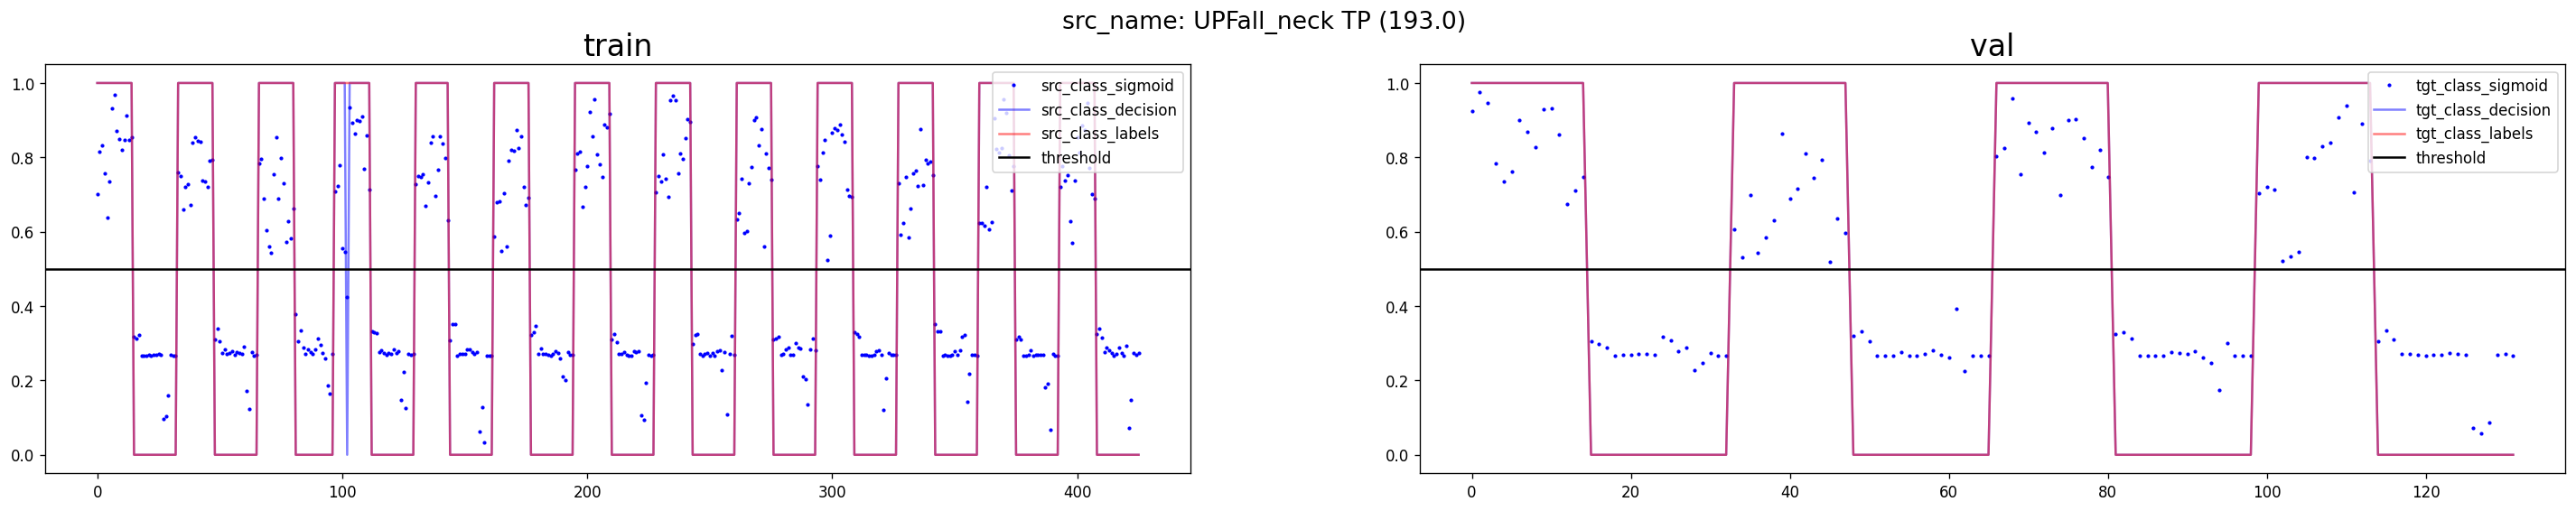

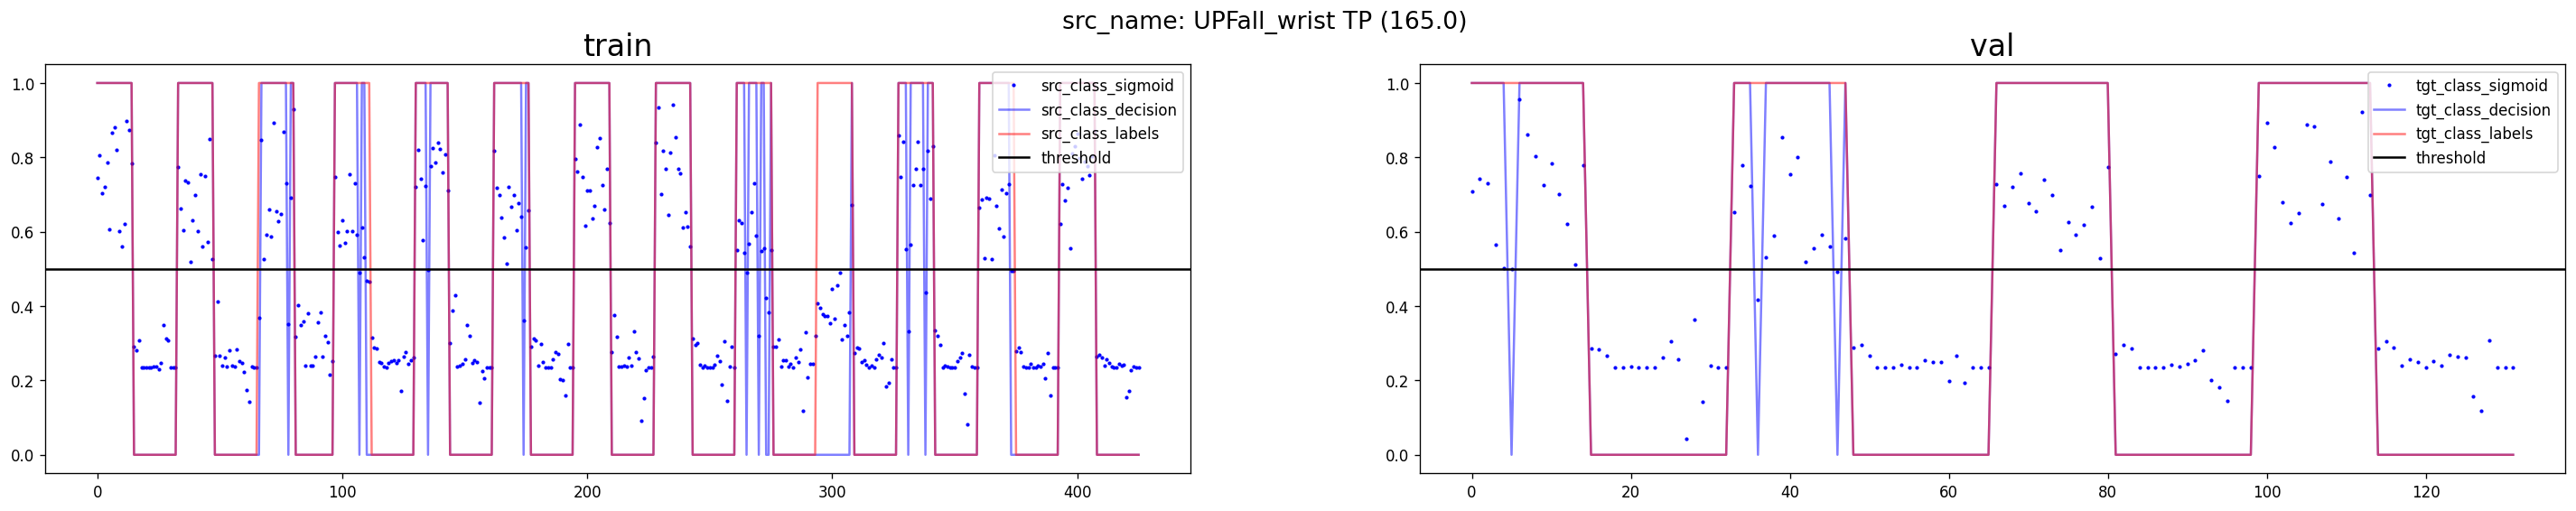

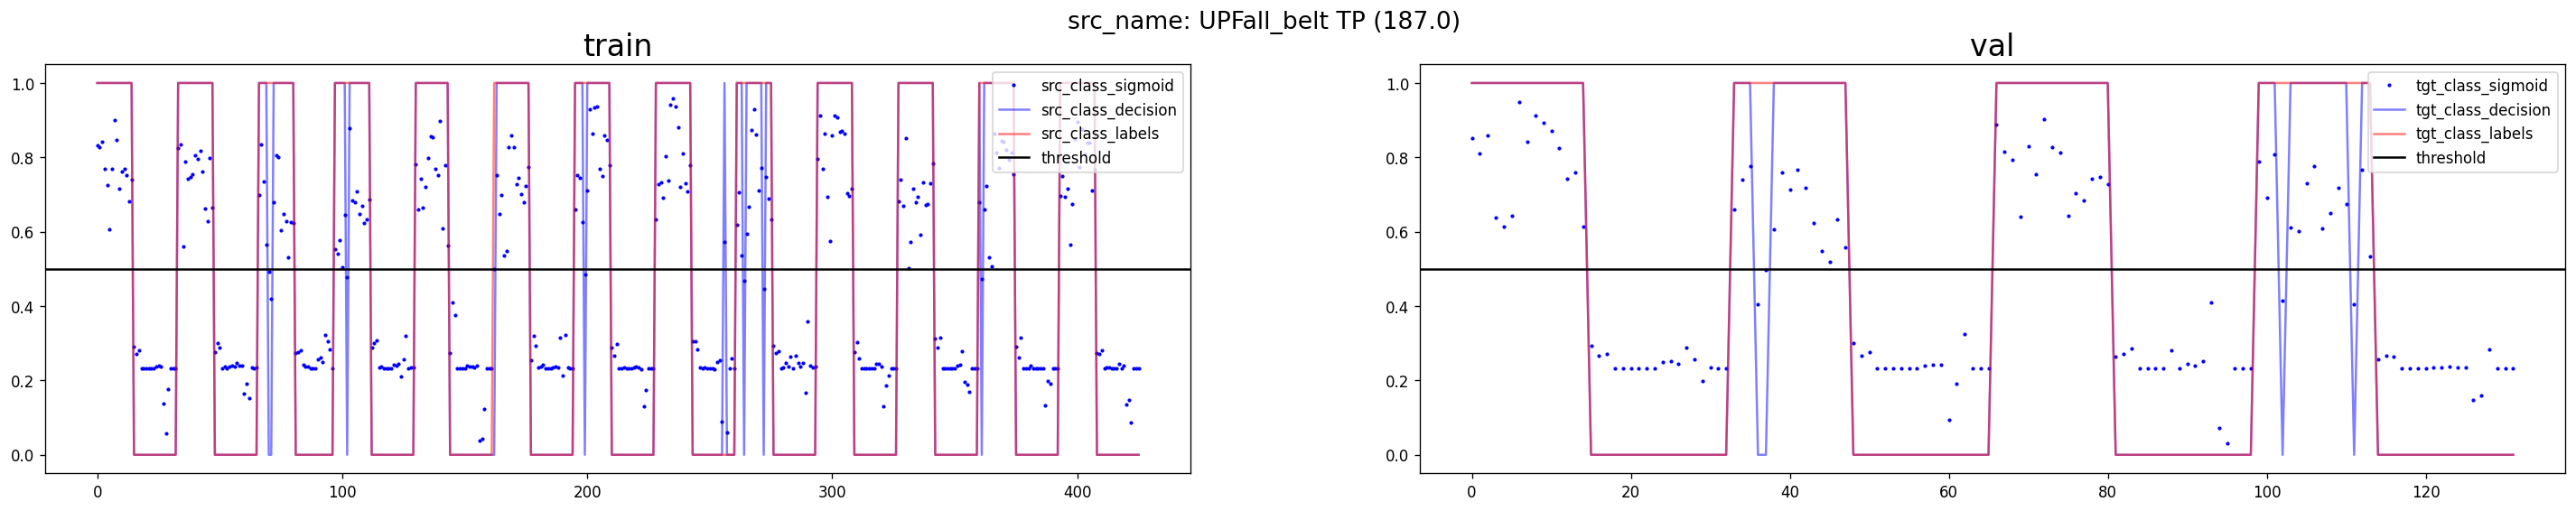

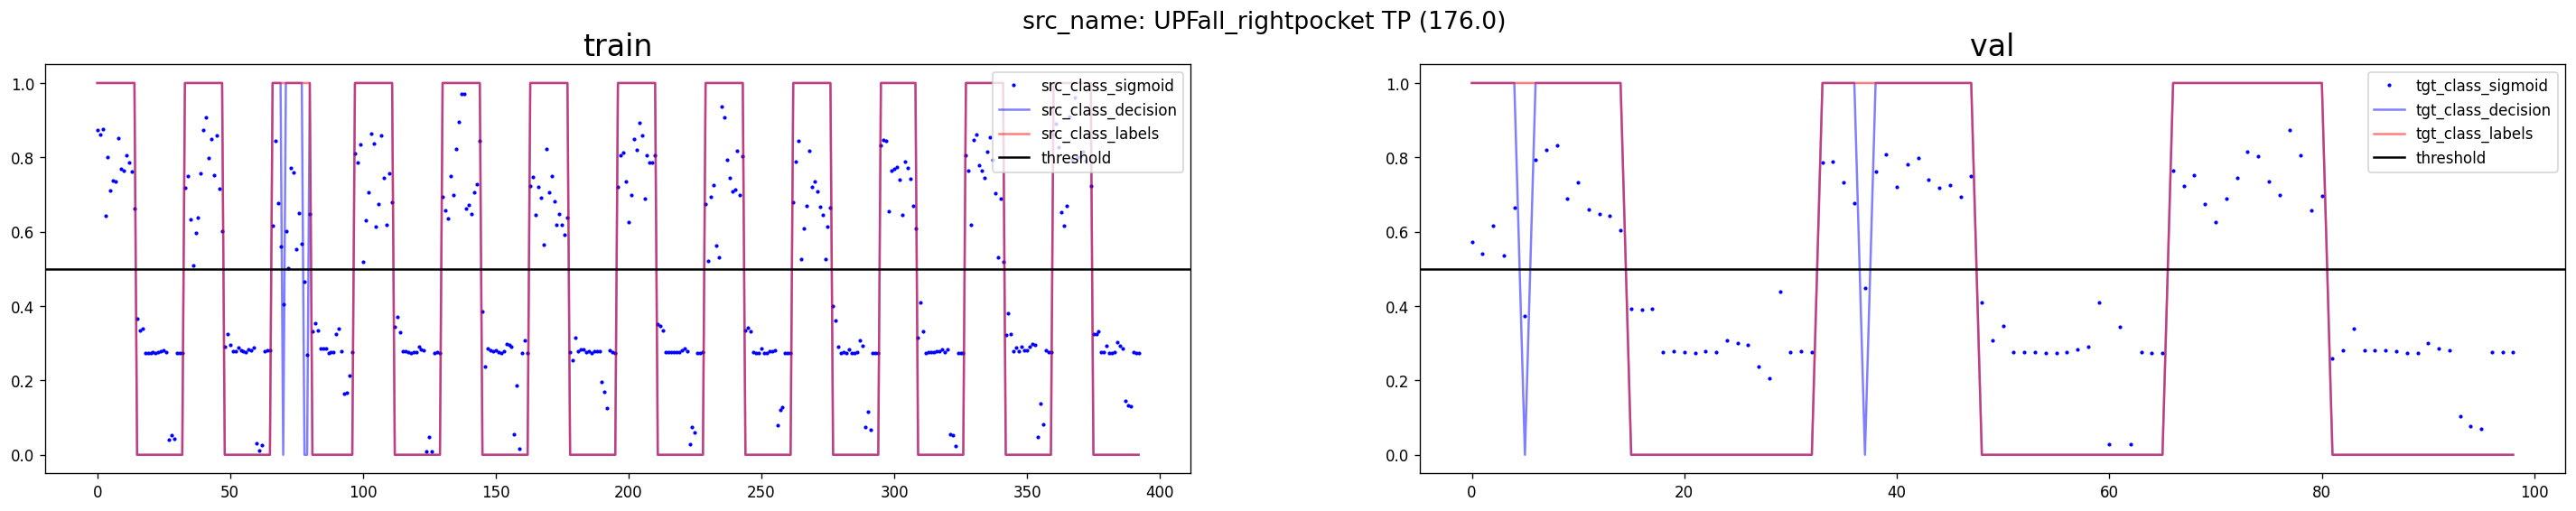

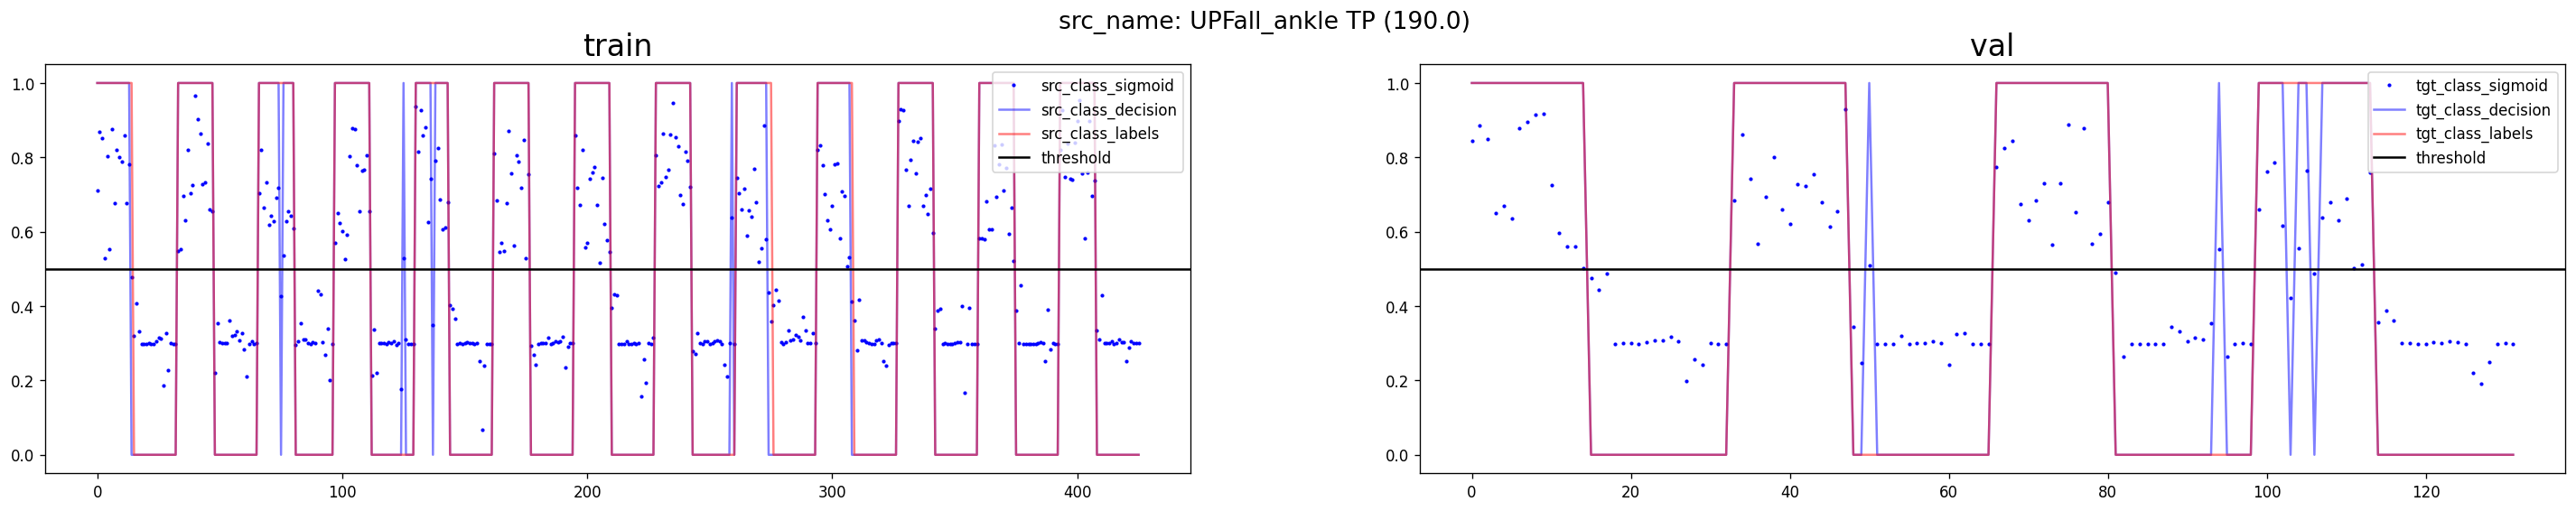

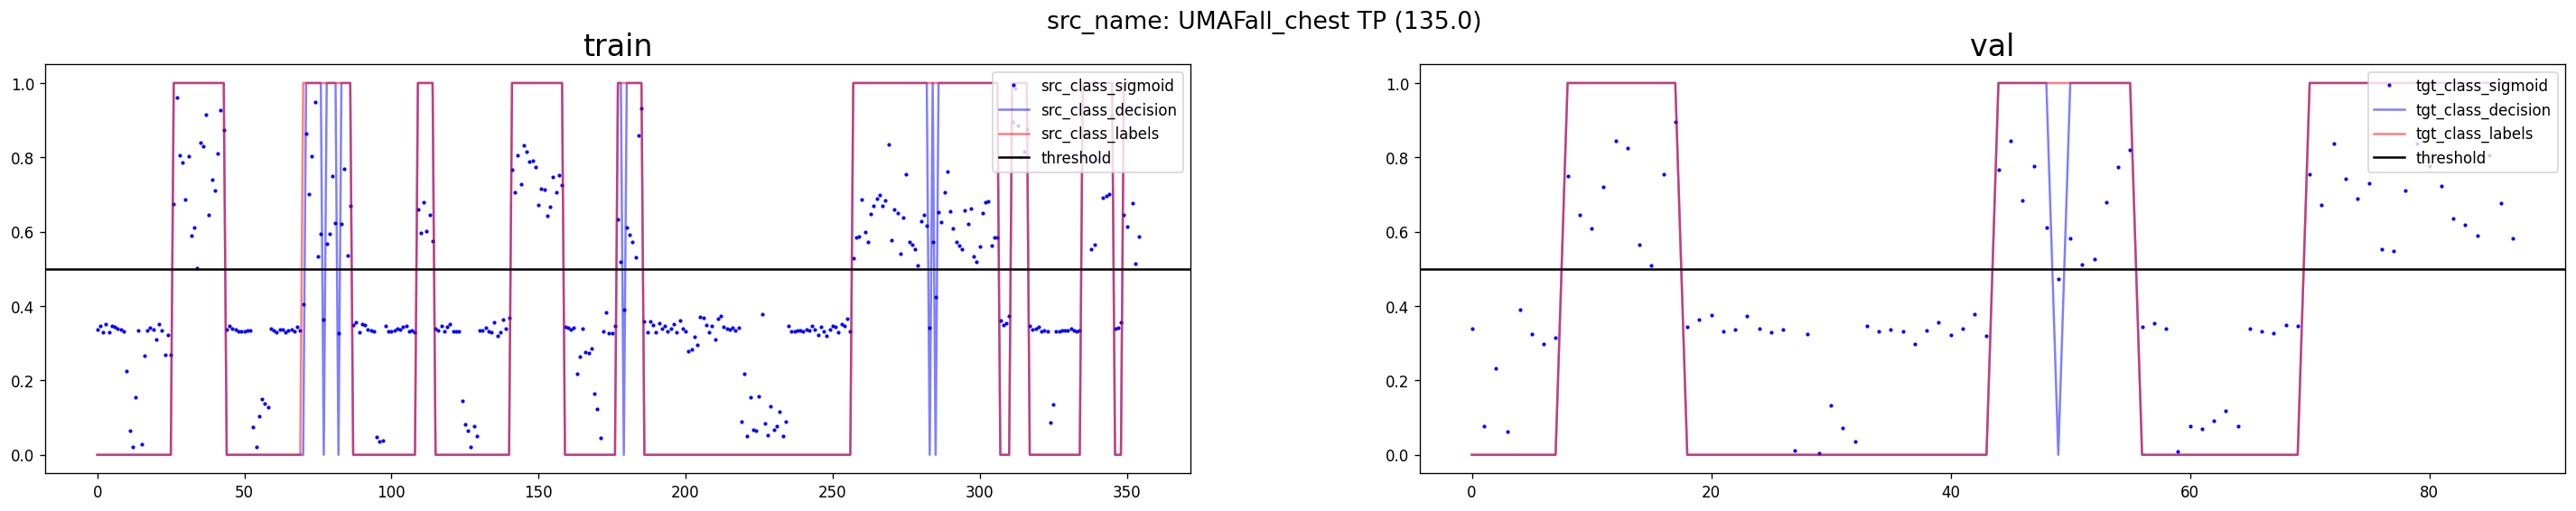

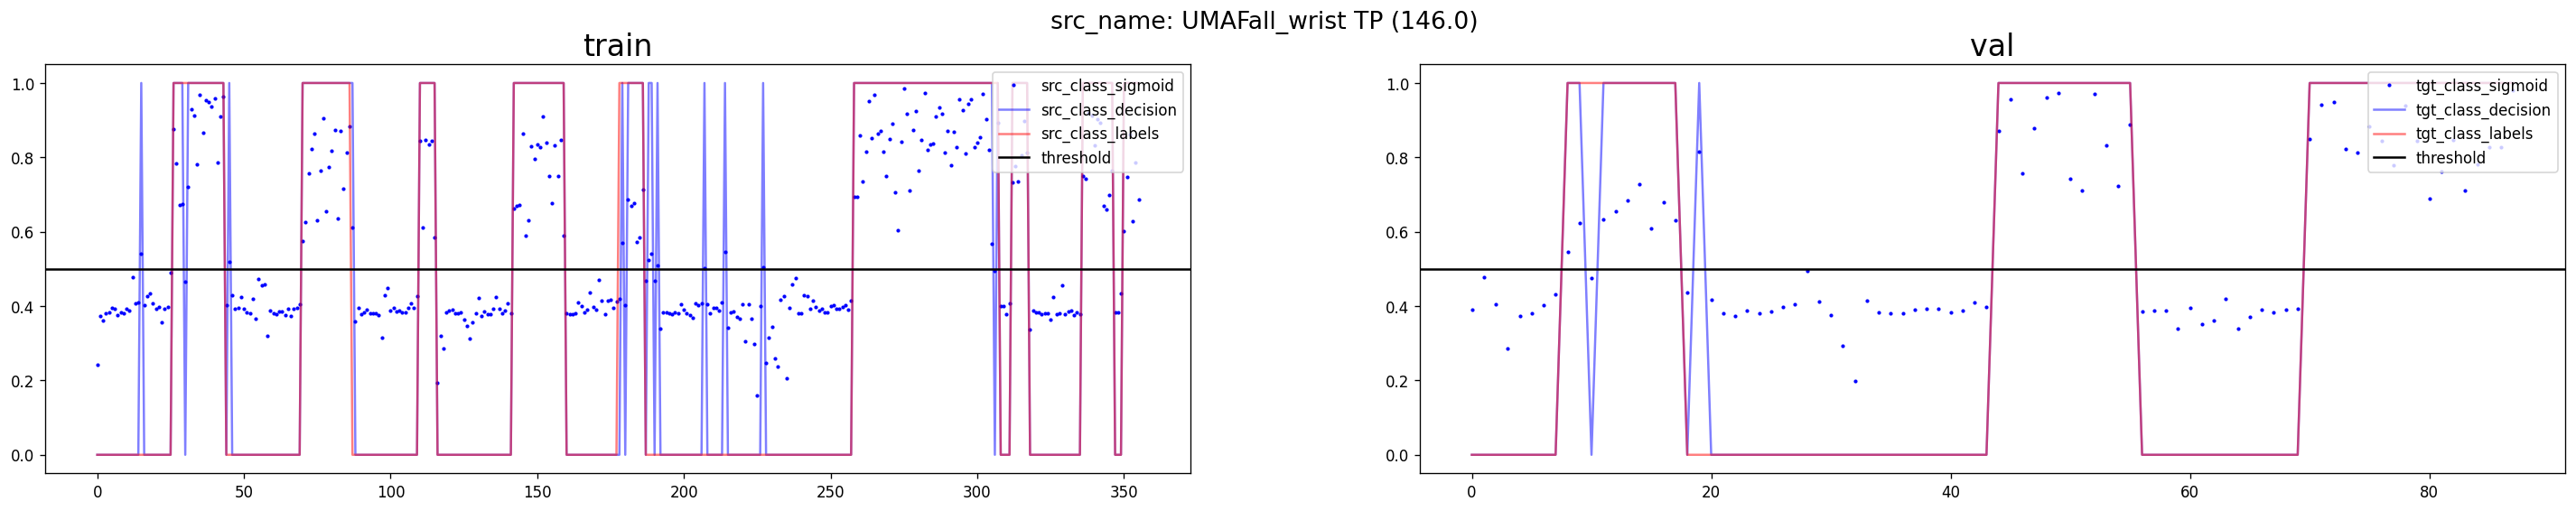

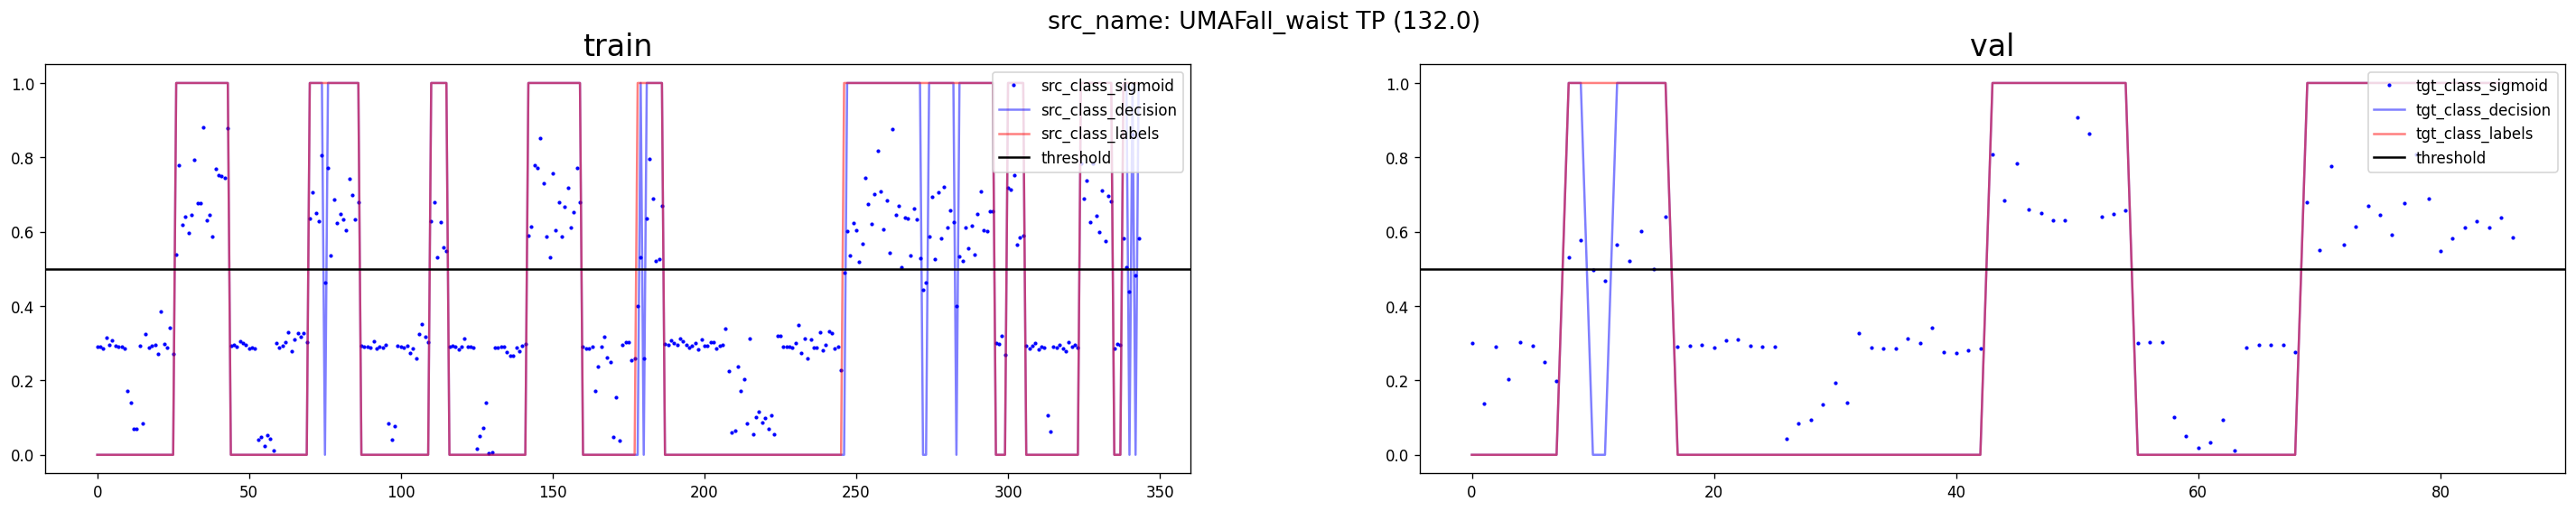

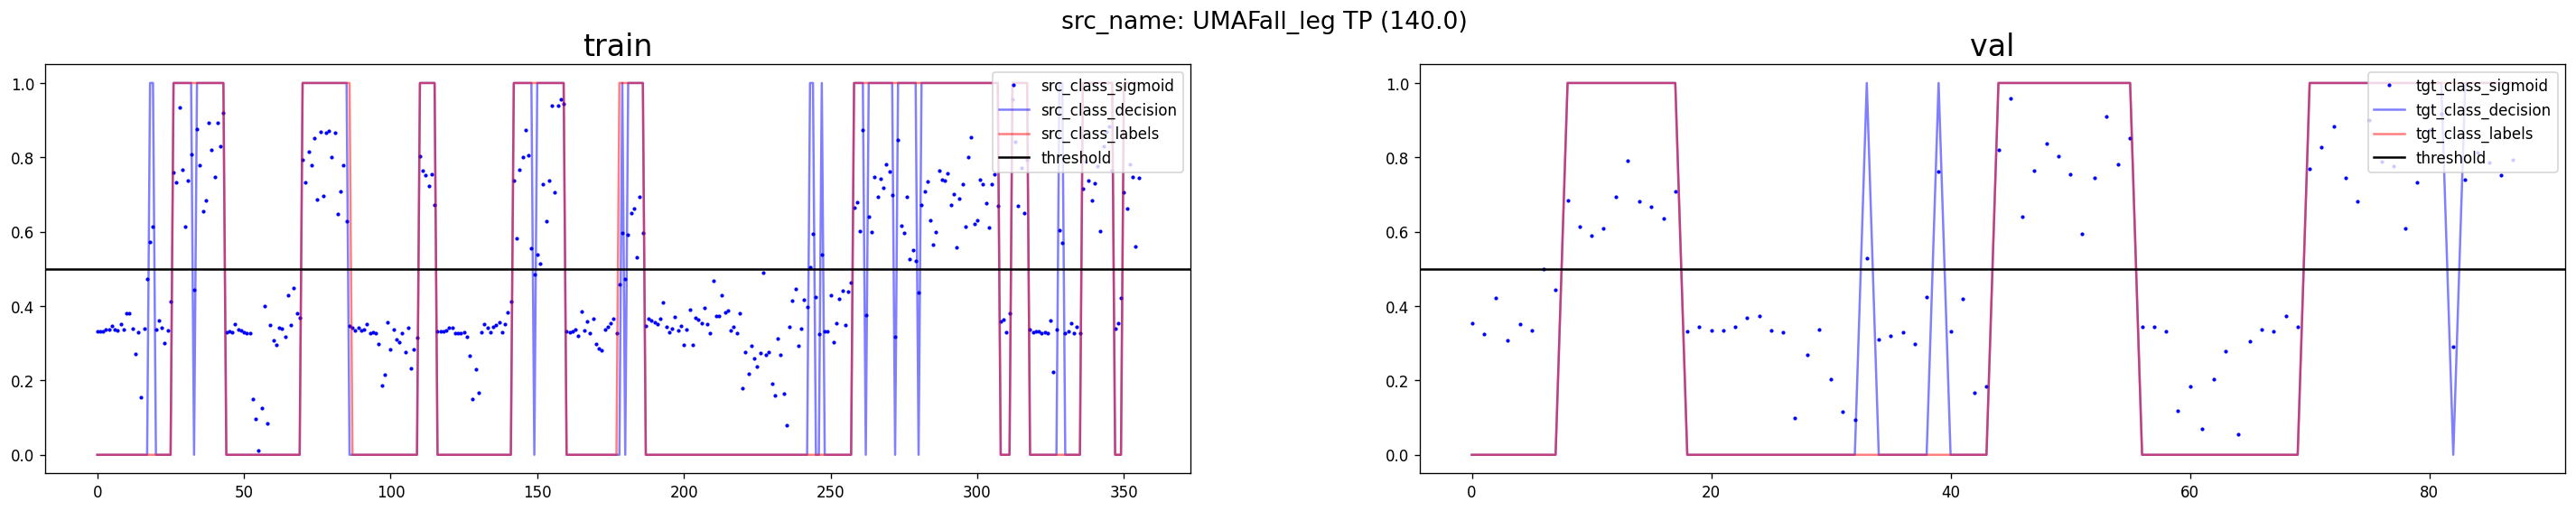

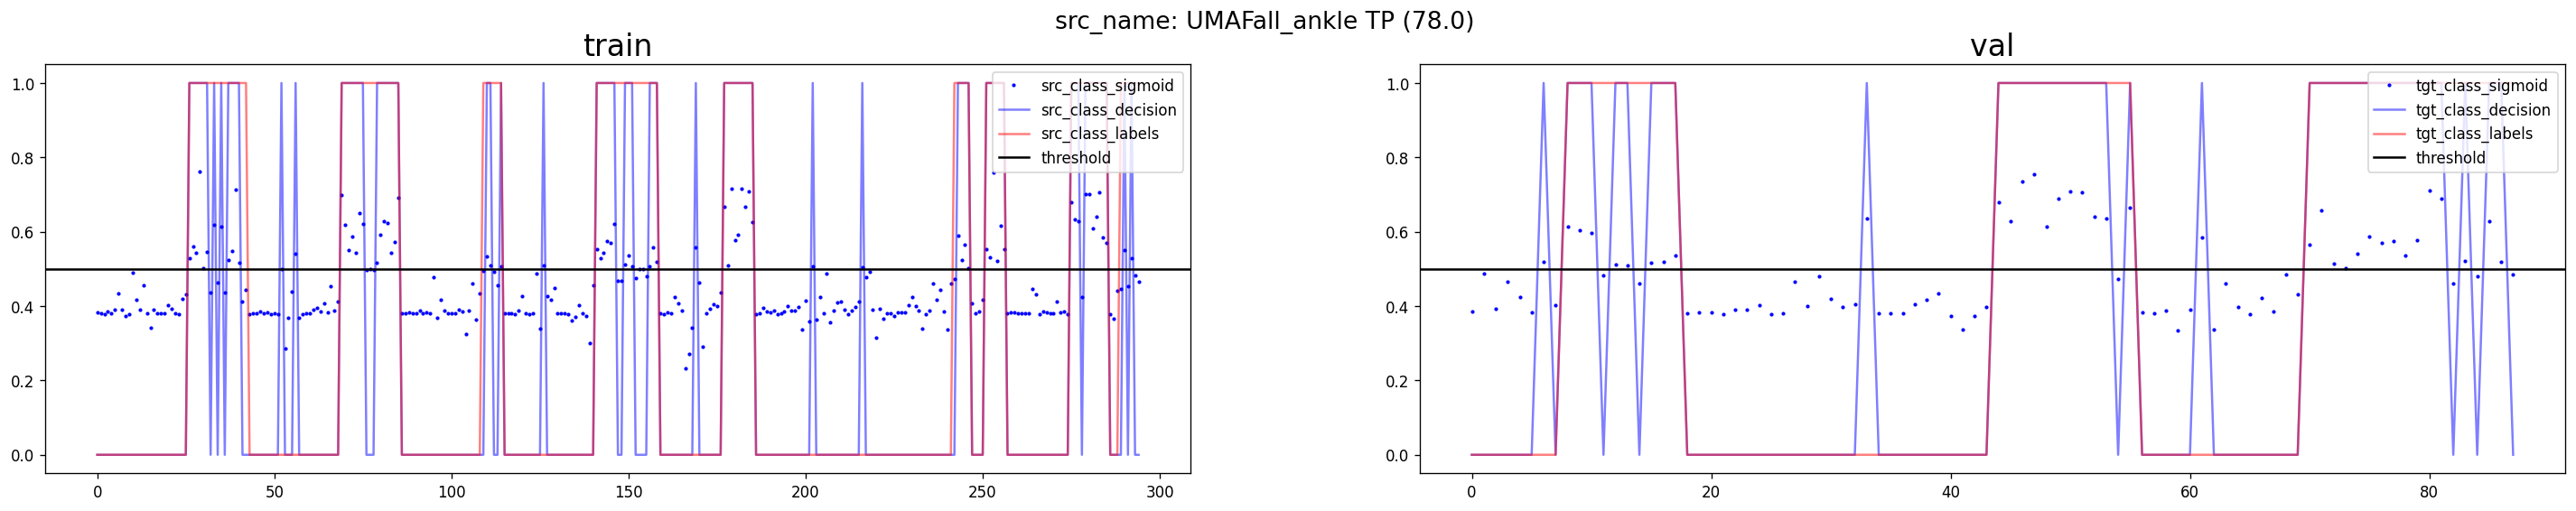

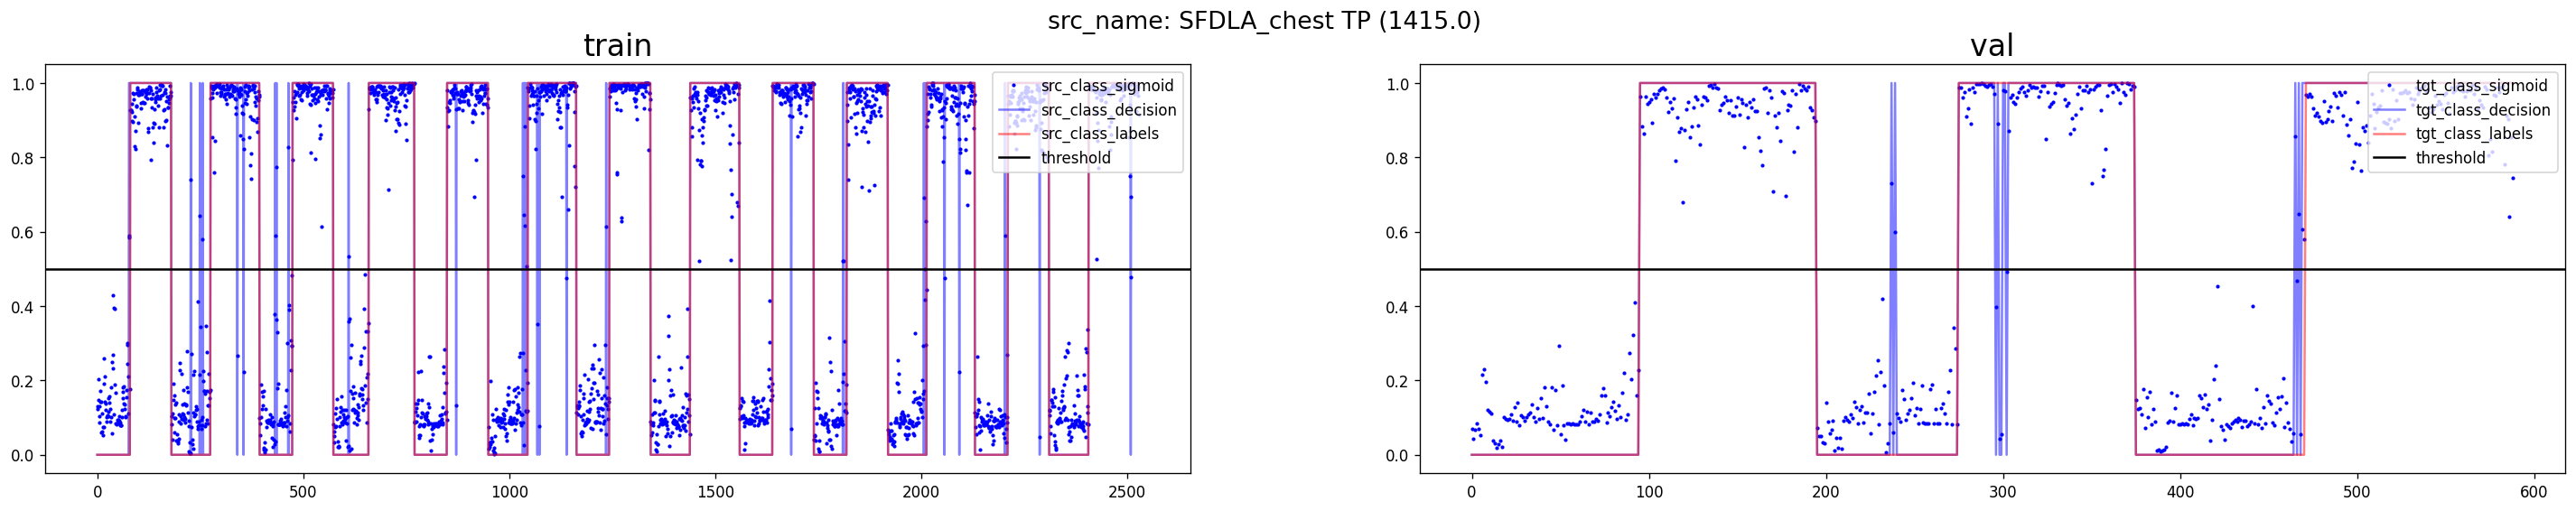

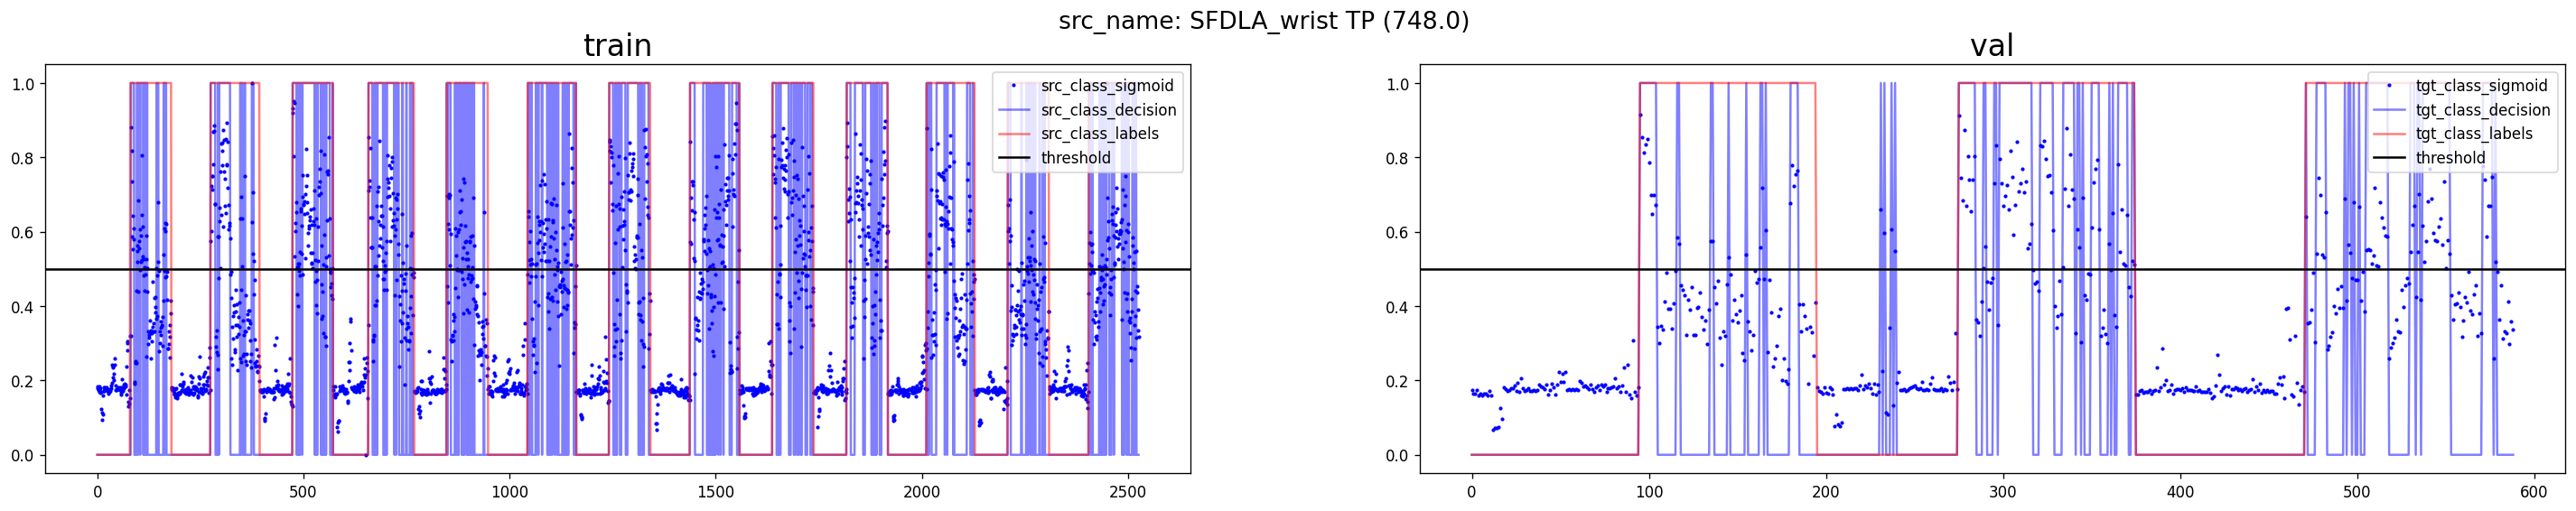

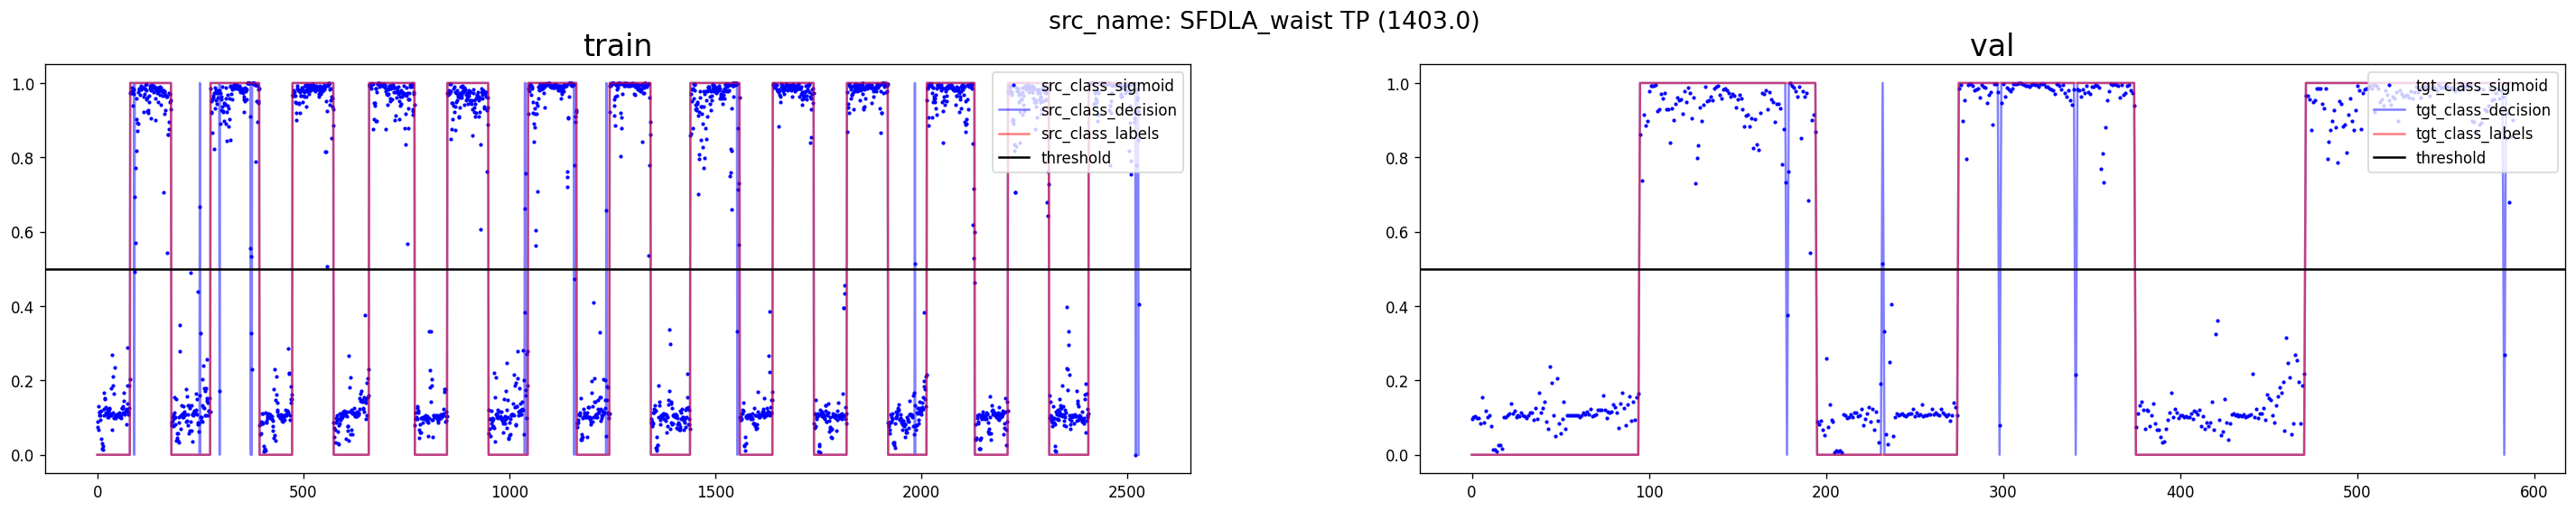

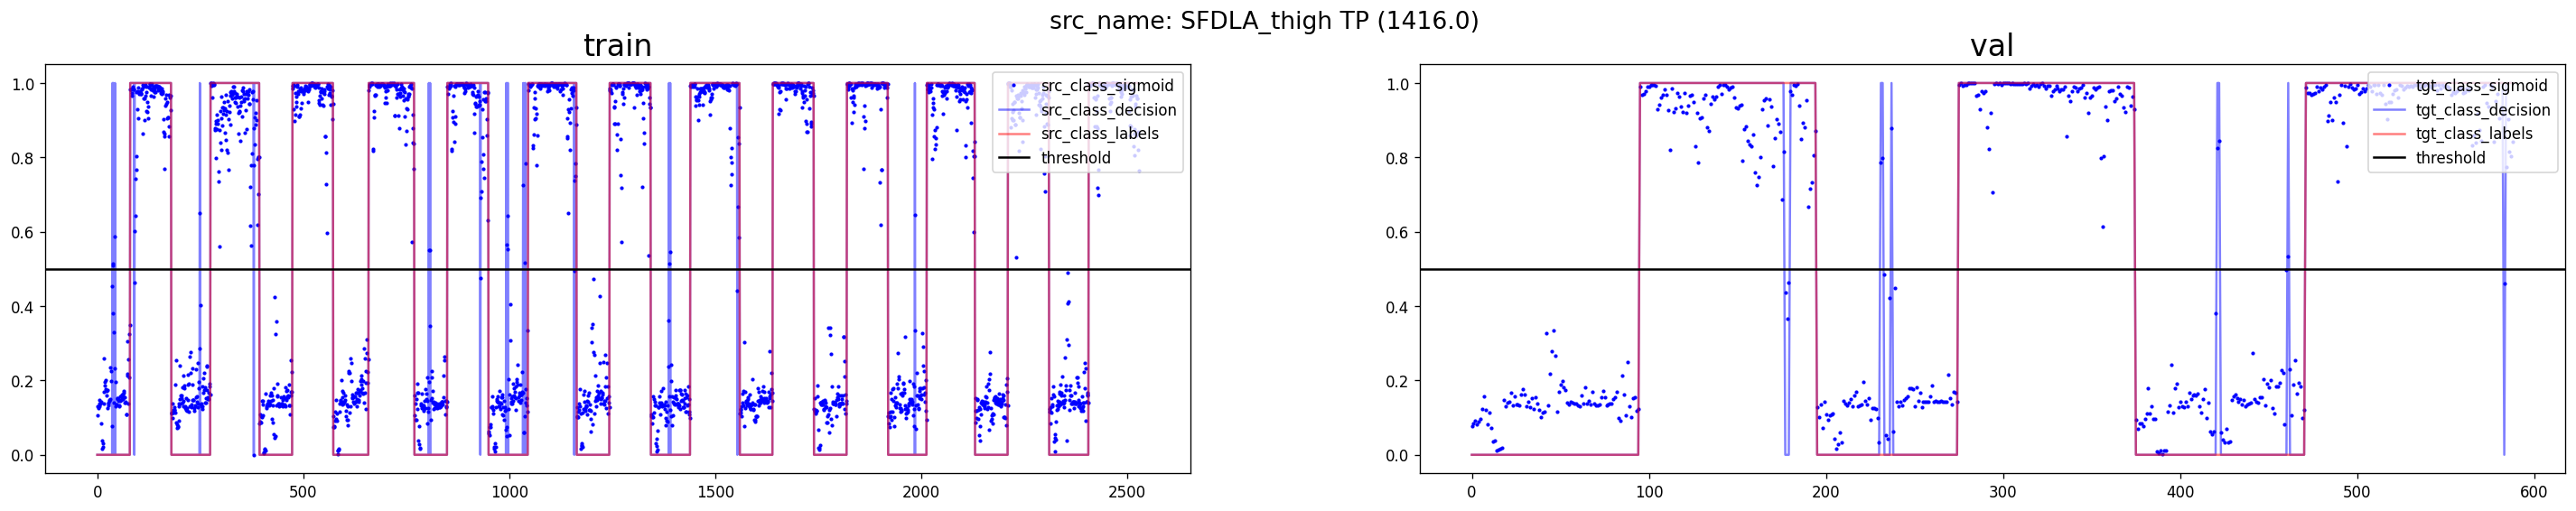

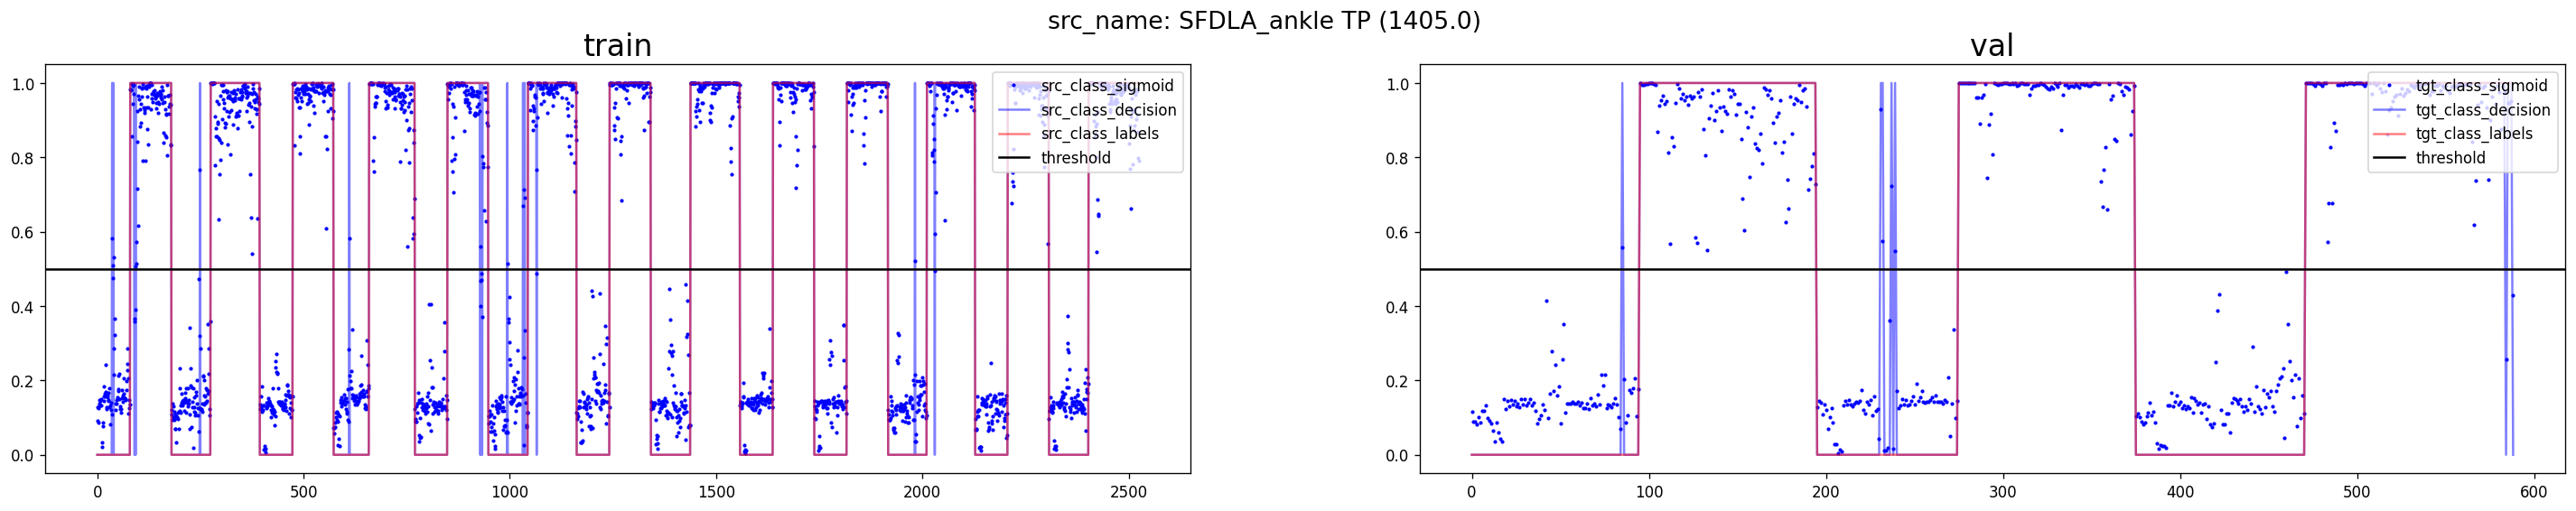

In [124]:
bad_src_names_list = []
results_train = {}
results_val = {}
    
for src_name in src_names:
    print('\n\nsrc_name: ', src_name)

    # TODO: don't need to extract training_params
    classes_n = training_params['classes_n']
    CV_n = training_params['CV_n']
    num_epochs = training_params['num_epochs']
    channel_n = training_params['channel_n']
    batch_size = training_params['batch_size']
    learning_rate = training_params['learning_rate']
    extractor_type = training_params['extractor_type']
    device = training_params['device']
    show_diagnosis_plt = training_params['show_diagnosis_plt']

    src_dataset_name = src_name.split('_')[0]
    src_sensor_loc = src_name.split('_')[1]


    src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)


    print('------------------------------Working on i_CV {}------------------------------'.format(i_CV))
    # 1. prepare dataset
    src_train_loader, src_val_loader = get_data_loader(src_inputdir, i_CV, batch_size, learning_rate)

    # the model expect the same input dimension for src and tgt data
    src_train_size = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
    src_val_size = src_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

    src_input_dim = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]

    # 2. prepare model

    total_step = len(src_train_loader)

    train_performance_dict_list = list( {} for i in range(num_epochs) )
    val_src_performance_dict_list = list( {} for i in range(num_epochs) )

    if extractor_type == 'CNN':
        model = DannModel2(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#         model = DannModel(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
    elif extractor_type == 'CNNLSTM':
        dropout = training_params['dropout']
        hiddenDim_f = training_params['hiddenDim_f']
        hiddenDim_y = training_params['hiddenDim_y']
        hiddenDim_d = training_params['hiddenDim_d']
        win_size = training_params['win_size']
        win_stride = training_params['win_stride']
        step_n = training_params['step_n']
        model = CnnLstm(device, class_N=classes_n, channel_n=channel_n, dropout=dropout, hiddenDim_f=hiddenDim_f, hiddenDim_y=hiddenDim_y, hiddenDim_d=hiddenDim_d, win_size=win_size, win_stride=win_stride, step_n=step_n).to(device)

    model_name = model.__class__.__name__
    # loss and optimizer
    class_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

#     plot_epoch(src_train_loader, src_val_loader, model)
    # 3. fit the model
    for epoch in range(num_epochs):
        train_performance_dict = train_epoch(src_train_loader, device, model, class_criterion, optimizer, epoch)
        
        train_performance_dict = val_epoch(src_train_loader, device, model, class_criterion, optimizer, epoch, 'src')
        train_performance_dict_list[epoch] = train_performance_dict

        val_src_performance_dict = val_epoch(src_val_loader, device, model, class_criterion, optimizer, epoch, 'src')
        val_src_performance_dict_list[epoch] = val_src_performance_dict
        
    torch.cuda.empty_cache()

    plot_epoch(src_train_loader, src_val_loader, model, src_name)
    

    print(src_name, train_performance_dict_list[epoch]['src_sensitivity'])
    results_train[src_name] =  train_performance_dict_list[epoch]['src_sensitivity']
    results_val[src_name] =  val_src_performance_dict_list[epoch]['src_sensitivity']
    
    if train_performance_dict_list[epoch]['src_sensitivity'] < 0.7:
        print('{} is bad src'.format(src_name))
        bad_src_names_list.append(src_name)
        
#     sys.exit()

        
print(bad_src_names_list)
print('train results')
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_train)
print('val results')
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_val)

# functions developed

In [ ]:
# # validated, the implementation is correct
# def contextExapansion(x, win_size, win_overlap, step_n):
#   # size of x: torch.Size([batch_size, channel_n, input_size])
#   # size of x_seq: torch.Size([step_n, batch_size, channel_n, win_size])

#   batch_size = x.size()[0]
#   channel_n = x.size()[1]
#   input_size = x.size()[2]

#   x_seq = torch.ones((step_n, batch_size, channel_n, win_size), dtype=torch.double)
#   timesteps = np.asarray(range(win_size))
#   for i in range(step_n):
#     indices = i*win_size*win_overlap+timesteps
#     x_seq[i, :, :, :] = x[:,:,indices]
#   return x_seq

# def labelExapansion(y, step_n):
#   # size of y: torch.Size([batch_size, 1])
#   # size of y_seq: torch.Size([batch_size, step_n])

#   batch_size = y.size()[0]

#   y_seq = torch.ones((step_n, batch_size), dtype=torch.double)
#   timesteps = np.asarray(range(win_size))
#   for i in range(step_n):
#     y_seq[i, :] = y
#   return y_seq

# win_size=22
# win_overlap=0.5
# step_n = 5
# x = torch.zeros((16,3,66), dtype=torch.double)
# y = torch.zeros((16,), dtype=torch.double)
# x_seq = contextExapansion(x, win_size, win_overlap, step_n)
# y_seq = labelExapansion(y, step_n)
# print(x.size(), x_seq.size(), y_seq.size(), y.size())

In [ ]:
# # validated, the implementation is correct
# def contextExapansion_v2(x, win_size, win_stride, step_n):
#   # size of x: torch.Size([batch_size, channel_n, input_size])
#   # size of x_seq: torch.Size([step_n, batch_size, channel_n, win_size])

#   batch_size = x.size()[0]
#   channel_n = x.size()[1]
#   input_size = x.size()[2]

#   x_seq = torch.ones((step_n, batch_size, channel_n, win_size), dtype=torch.double)
#   timesteps = np.asarray(range(win_size))
#   for i in range(step_n):
#     indices = i*win_stride+timesteps
#     x_seq[i, :, :, :] = x[:,:,indices]
#   return x_seq

# def labelExapansion(y, step_n):
#   # size of y: torch.Size([batch_size, 1])
#   # size of y_seq: torch.Size([batch_size, step_n])

#   batch_size = y.size()[0]

#   y_seq = torch.ones((step_n, batch_size), dtype=torch.double)
#   timesteps = np.asarray(range(win_size))
#   for i in range(step_n):
#     y_seq[i, :] = y
#   return y_seq

# win_size=24
# win_stride=7
# step_n = 7
# x = torch.zeros((16,3,66), dtype=torch.double)
# y = torch.zeros((16,), dtype=torch.double)
# x_seq = contextExapansion_v2(x, win_size, win_stride, step_n)
# y_seq = labelExapansion(y, step_n)
# print(x.size(), x_seq.size(), y_seq.size(), y.size())
# # print(x_seq)


In [ ]:

# # fall classifier neural network (fc layers)
# class ClassClassifier_lstm(nn.Module):
#   def __init__(self, num_classes=2, hiddenDim=16, input_dim=50, steps_n=5):
#       super(ClassClassifier_lstm, self).__init__()
#       self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
#         input_size=input_dim,
#         hidden_size=hiddenDim,         # rnn hidden unit
#         num_layers=2,           # number of rnn layer
#         batch_first=False,       # input & output will has not batch size as 1st dimension. e.g. (time_step, time_step, input_size)
#         bidirectional=True,
#       )
#       self.fc1 = nn.Linear(steps_n*hiddenDim*2, 10)
#       self.fc2 = nn.Linear(10, num_classes)
#       self.relu = nn.ReLU(inplace=False)
#       self.fc3 = nn.Linear(steps_n*hiddenDim*2, num_classes)

#       # self.lsm = nn.LogSoftmax(dim=1)
      
#   def forward(self, x):
#     debug = False
#     # Input: (seq_len, batch, input_size)
#     # Output: (seq_len, batch, num_directions * hidden_size)
#     out1_seq, (h_n, h_c) = self.lstm(x)
#     out1_seq = out1_seq.transpose(0,1)
#     out1_seq = out1_seq.reshape(out1_seq.size()[0],-1)

#     out2 = self.relu(self.fc1(out1_seq))
#     out3 = self.fc2(out2)
#     # out3 = self.fc3(out1_seq)

#     if debug:
#       print('ClassClassifier_lstm')
#       print('out1_seq size:', out1_seq.size())
#       print('out2 size:', out2.size())
#       print('out3 size:', out3.size())

#     return out3

# # domain classifier neural network (fc layers)
# class DomainClassifier_lstm(nn.Module):
#   def __init__(self, num_classes=2, hiddenDim=16, input_dim=50, steps_n=5):
#       super(DomainClassifier_lstm, self).__init__()
#       self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
#         input_size=input_dim,
#         hidden_size=hiddenDim,         # rnn hidden unit
#         num_layers=2,           # number of rnn layer
#         batch_first=False,       # input & output will has not batch size as 1st dimension. e.g. (time_step, time_step, input_size)
#         bidirectional=True,
#       )
#       self.fc1 = nn.Linear(steps_n*hiddenDim*2, 10)
#       self.fc2 = nn.Linear(10, num_classes)
#       self.relu = nn.ReLU(inplace=False)
#       # self.lsm = nn.LogSoftmax(dim=1)
      
#   def forward(self, x, constant):
#     debug = False

#     x = GradReverse.grad_reverse(x.float(), constant)

#     out1_seq, (h_n, h_c) = self.lstm(x)
#     out1_seq = out1_seq.transpose(0,1)
#     out1_seq = out1_seq.reshape(out1_seq.size()[0],-1)
#     # print('out1_seq', out1_seq)

#     out2 = self.relu(self.fc1(out1_seq))
#     out3 = self.fc2(out2)
#     # out3 = self.lsm(self.fc2(out2))
#     # print('out3', out3)

#     if debug:
#       print('DomainClassifier_lstm')
#       print('out1_seq size:', out1_seq.size())
#       print('out2 size:', out2.size())
#       print('out3 size:', out3.size())
      
#     return out3


In [ ]:
# # Convolutional neural network (two convolutional layers)
# class CnnLstm(nn.Module):
#   def __init__(self, device, class_N=2, channel_n=16, dropout=0.5, hiddenDim_f=5, hiddenDim_y=5, hiddenDim_d=5, win_size=22, win_overlap=0.5, step_n=5):
#       super(CnnLstm, self).__init__()
#       self.win_size = win_size
#       self.win_overlap = win_overlap
#       self.step_n = step_n
#       self.feature_extractor = FeatureExtractor(input_dim=win_size, channel_n=channel_n).to(device).float()

#       cnn_layer1_dim = (win_size+2*2-1*(3-1)-1)+1
#       pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1
#       cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#       pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1
#       self.feature_out_dim = int(pool_layer2_dim*channel_n*2)

#       # lstm_out_seq size: torch.Size([step_n, batch_size, hiddenDim*2])
#       self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
#         input_size=self.feature_out_dim,
#         hidden_size=hiddenDim_f,         # rnn hidden unit
#         num_layers=2,           # number of rnn layer
#         batch_first=False,       # input & output will has not batch size as 1st dimension. e.g. (time_step, batch, input_size)
#         bidirectional=True,
#         dropout=dropout
#       ).to(device).float()


#       # self.class_classifier = ClassClassifier_lstm(num_classes=2, hiddenDim=hiddenDim_y, input_dim=hiddenDim_f*2, steps_n=step_n).to(device).float()
#       # self.domain_classifier = DomainClassifier_lstm(num_classes=2, hiddenDim=hiddenDim_d, input_dim=hiddenDim_f*2, steps_n=step_n).to(device).float()
#       self.class_classifier = ClassClassifier_lstm(num_classes=2, hiddenDim=hiddenDim_y, input_dim=self.feature_out_dim, steps_n=step_n).to(device).float()
#       self.domain_classifier = DomainClassifier_lstm(num_classes=2, hiddenDim=hiddenDim_d, input_dim=self.feature_out_dim, steps_n=step_n).to(device).float()
      

      
#   def forward(self, x):
#     # size of x: torch.Size([batch_size, channel_n, input_size])
#     # size of x_seq: torch.Size([step_n, batch_size, channel_n, win_size])
#     debug = False
#     x_seq = contextExapansion(x, self.win_size, self.win_overlap, self.step_n).to(device).float()
#     # aaa = x_seq[0,0,:,:].cpu().numpy().T
#     # bbb = x_seq[1,0,:,:].cpu().numpy().T

#     # for i in range(5):
#     #   plt.subplot(5, 1, i+1)
#     #   plt.plot(x_seq[i,0,:,:].cpu().numpy().T)
#     #   plt.title('t={}'.format(i))
#     #   # plt.ylabel('t=0')
#     # plt.show()

#     feature_out_seq = torch.ones((self.step_n, x.size()[0], self.feature_out_dim), dtype=torch.float).to(device)

#     for t in range(self.step_n):
#       # Input: (N, C_in, L_in)
#       # Output: (N, L_out=self.feature_out_dim*C_out)
#       feature_out_seq[t,:,:] = self.feature_extractor(x_seq[t,:,:,:])
    
#     lstm_out_seq = feature_out_seq
#     # Input: (seq_len, batch, input_size)
#     # Output: (seq_len, batch, num_directions * hidden_size)
#     # lstm_out_seq, (h_n, h_c) = self.lstm(feature_out_seq, None)

#     # print(lstm_out_seq)
#     # sys.exit()
#     class_output = self.class_classifier(lstm_out_seq)
#     domain_output = self.domain_classifier(lstm_out_seq, 1)

#     if debug:
#       print('CnnLstm')
#       print('x size:', x.size())
#       print('x_seq size:', x_seq.size())
#       print('feature_out_seq size:', feature_out_seq.size())

#       print('lstm_out_seq size:', lstm_out_seq.size())
#       print('class_output size:', class_output.size())
#       print('domain_output size:', domain_output.size())

#     lstm_out_seq = lstm_out_seq.transpose(0,1)
#     lstm_out_seq = lstm_out_seq.reshape(lstm_out_seq.size()[0],-1)

#     # print('lstm_out_seq', lstm_out_seq)
#     return lstm_out_seq, class_output, domain_output



In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# # device = torch.device('cpu')
# print('show GPU device name:', torch.cuda.get_device_name(0))
# model_1 = FeatureExtractor(input_dim=66).to(device).float()

# # test_input = torch.randn((8, 3, 66), dtype=torch.double)

# # test_input = test_input.to(device)
#     # labels = labels.to(device).long()

# feature_out = model_1(test_input)
# print('show model_1 output size:', feature_out.size())

# feature_out.data.detach().cpu().numpy()

# feature_out_dim =  feature_out.size()[1]
# model_2 = ClassClassifier(num_classes=2, input_dim=feature_out_dim).to(device).float()
# model_3 = DomainClassifier(num_classes=2, input_dim=feature_out_dim).to(device).float()

# model_2_out = model_2(feature_out)
# print('show model_2 output size:', model_2_out.size())

# model_3_out = model_3(feature_out, 1)
# print('show model_3 output size:', model_3_out.size())

# model_4 = CascadedModel(model_1, model_2)
# # model_4 = nn.Sequential(model_1, model_2)

# print('model_4 output size', model_4(test_input).size())

# dann = DannModel(device, class_N=2, domain_N=2, channel_n=5, input_dim=66).to(device).float()
# feature_out, class_output, domain_output = dann(test_input)
# print('dann output size', feature_out.size(), class_output.size(), domain_output.size())




# testing performance

In [ ]:
win_size = 18

cnn_layer1_dim = (win_size+2*2-1*(3-1)-1)+1
pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1
cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

print('win_size, cnn_layer1_dim, pool_layer1_dim, cnn_layer2_dim, pool_layer2_dim size:', win_size, cnn_layer1_dim, pool_layer1_dim, cnn_layer2_dim, pool_layer2_dim)


win_size, cnn_layer1_dim, pool_layer1_dim, cnn_layer2_dim, pool_layer2_dim size: 18 20 10.0 12.0 6.0


In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
# print('show GPU device name:', torch.cuda.get_device_name(0))

batch_size = 253
axis_dim = 3
input_size = 66
test_input = torch.randn((batch_size, axis_dim, input_size), dtype=torch.double).to(device)
print('test_input size:', test_input.size())

channel_n = 4
# model = CnnLstm(device, class_N=2, channel_n=channel_n, dropout=0.5, hiddenDim_f=5, hiddenDim_y=5, hiddenDim_d=5, win_size=22, win_stride=11, step_n=5).to(device)
model = CnnLstm(device, class_N=2, channel_n=channel_n, dropout=0.5, hiddenDim_f=5, hiddenDim_y=5, hiddenDim_d=5, win_size=18, win_stride=6, step_n=9).to(device)
print(model)
lstm_out_seq, class_output, domain_output = model(test_input)

dann = DannModel(device, class_N=2, domain_N=2, channel_n=channel_n, input_dim=66).to(device).float()

print(lstm_out_seq.size())
print('show lstm_out_seq, class_output, domain_output size:', lstm_out_seq.size(), class_output.size(), domain_output.size())


cuda:0
test_input size: torch.Size([253, 3, 66])
FeatureExtractor_total_params: 168


/home/mchan2020/miniconda3/envs/FD_DAT/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CnnLstm_total_params: 27434
CnnLstm(
  (feature_extractor): FeatureExtractor(
    (layer1): Sequential(
      (0): Conv1d(3, 4, kernel_size=(3,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (class_classifier): ClassClassifier_lstm(
    (lstm): LSTM(48, 5, dropout=0.5, bidirectional=True)
    (fc1): Linear(in_features=90, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=2, bias=True)
    (relu): ReLU()
    (fc3): Linear(in_features=90, out_features=2, bias=True)
  )
  (domain_classifier

In [ ]:
# optimal

# tasks_list = [('UMAFall_waist', 'UPFall_belt')]
# tasks_list = [('UPFall_belt', 'UMAFall_waist')]
# tasks_list = [('UPFall_belt', 'UMAFall_waist')]
tasks_list = [('UMAFall_ankle', 'UPFall_ankle')]
# tasks_list = [('UMAFall_wrist', 'UPFall_wrist')]
# tasks_list = [('UMAFall_leg', 'UPFall_rightpocket')]

CV_n = 3
num_epochs = 10
extractor_type = 'CNNLSTM'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


training_params = {
  'classes_n': 2,
  'CV_n': CV_n,
  'num_epochs': num_epochs,
  'channel_n': 16,
  'batch_size': 16,
  'learning_rate': 0.001,
  'extractor_type': extractor_type,
  'device': device,
  'dropout': 0.5,
  'hiddenDim_f': 5,
  'hiddenDim_y': 5,
  'hiddenDim_d': 5,
  'win_size': 18,
  'win_stride': 6,
  'step_n': 9,
  }

# for i, training_params in enumerate(training_params_list):
df_performance_table = pd.DataFrame('', index=['source', 'DANN', 'target', 'domain'], columns=[])

for task_item in tasks_list:
  start_time = time.time()

  (src_name, tgt_name) = task_item

  inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
  outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO_testing/{}_{}/'.format(src_name, tgt_name)
  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
  print('outputdir for stage2 output:', outputdir)

  df_performance_table = performance_table(df_performance_table, src_name, tgt_name, training_params, inputdir, outputdir)

  time_elapsed = time.time() - start_time
  print('time elapsed:', time_elapsed)
  df_performance_table.loc['time_elapsed'] = time_elapsed

  df_outputdir = outputdir

  print('df_performance_table saved at', df_outputdir)
  df_performance_table.to_csv(df_outputdir+'df_performance_table_optimal.csv', encoding='utf-8')

  display(df_performance_table)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
display(df_performance_table)

,UMAFall_ankle_UPFall_ankle
source,0.333±0.109
DANN,0.263±0.245
target,0.838±0.046
domain,0.794±0.328
time_elapsed,134.21


In [ ]:
# # training_params = {
# #   'classes_n': 2,
# #   'CV_n': 2,
# #   'num_epochs': 10,
# #   'channel_n': 4,
# #   'batch_size': 32,
# #   'learning_rate': 0.01,
# #   'extractor_type': 'CNN',}
# training_params = {
#   'classes_n': 2,
#   'CV_n': 2,
#   'num_epochs': 10,
#   'channel_n': 4,
#   'batch_size': 32,
#   'learning_rate': 0.01,
#   'extractor_type': 'CNNLSTM',
#   'dropout': 0,
#   'hiddenDim_f': 5,
#   'hiddenDim_y': 5,
#   'hiddenDim_d': 5,
#   'win_size': 22,
#   'win_overlap': 0.5,
#   'step_n': 5,
#   }

# tasks_list = [('UMAFall_leg', 'UPFall_rightpocket')]
# (src_name, tgt_name) = tasks_list[0]
# inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
# outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO_testing/{}_{}/'.format(src_name, tgt_name)

# source_outputs = BaselineModel_fitting_2(training_params, src_name, tgt_name, inputdir, outputdir+'source/')


# fixing DannModel_fitting WIP

In [ ]:

# def DannModel_fitting(training_params, src_name, tgt_name, inputdir, outputdir): 

#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)

#   classes_n = training_params['classes_n']
#   CV_n = training_params['CV_n']
#   num_epochs = training_params['num_epochs']
#   channel_n = training_params['channel_n']
#   batch_size = training_params['batch_size']
#   learning_rate = training_params['learning_rate']

#   df_performance = pd.DataFrame(0, index=np.arange(CV_n), 
#                                 columns=['i_CV',
#                                         'train_src_class_loss','train_tgt_class_loss','train_src_domain_loss','train_tgt_domain_loss', 
#                                         'train_src_class_acc','train_tgt_class_acc','train_domain_acc',
#                                         'val_src_class_loss','val_tgt_class_loss','val_src_domain_loss','val_tgt_domain_loss',
#                                         'val_src_class_acc','val_tgt_class_acc','val_domain_acc'])

#   src_dataset_name = src_name.split('_')[0]
#   src_sensor_loc = src_name.split('_')[1]

#   tgt_dataset_name = tgt_name.split('_')[0]
#   tgt_sensor_loc = tgt_name.split('_')[1]

#   src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)
#   tgt_inputdir = inputdir + '{}/{}/'.format(tgt_dataset_name, tgt_sensor_loc)


#   for i_CV in range(CV_n):
#     print('------------------------------Working on i_CV {}------------------------------'.format(i_CV))
#     # 1. prepare dataset
#     src_train_loader, src_val_loader = get_UMAFall_loader(src_inputdir, i_CV, batch_size, learning_rate)
#     tgt_train_loader, tgt_val_loader = get_UPFall_loader(tgt_inputdir, i_CV, batch_size, learning_rate)

#     # the model expect the same input dimension for src and tgt data
#     src_train_size = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
#     src_val_size = src_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

#     tgt_train_size = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
#     tgt_val_size = tgt_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

#     src_input_dim = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]
#     tgt_input_dim = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]

#     # 2. prepare model
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#     # loss and optimizer
#     class_criterion = nn.CrossEntropyLoss()
#     domain_criterion = nn.CrossEntropyLoss()

#     # 3. fit the model
#     total_step = len(src_train_loader)

#     train_loss_avg_epochs = np.zeros(num_epochs)
#     train_src_class_acc_epochs = np.zeros(num_epochs)
#     train_tgt_class_acc_epochs = np.zeros(num_epochs)
#     train_domain_acc = np.zeros(num_epochs)
#     val_loss_avg_epochs = np.zeros(num_epochs)
#     val_src_class_acc_epochs = np.zeros(num_epochs)
#     val_tgt_class_acc_epochs = np.zeros(num_epochs)
#     val_domain_acc = np.zeros(num_epochs)

#     df_performance.loc[i_CV,'i_CV'] = i_CV
#     model = DannModel(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#     model_name = model.__class__.__name__
#     train_size = src_train_size+tgt_train_size
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

#     model_output_diagnosis_trainval(model, src_train_loader, tgt_train_loader, src_val_loader, tgt_val_loader, device, '_epoch{}'.format(0), i_CV, outputdir)
#     model_features_diagnosis_trainval(model, src_train_loader, tgt_train_loader, src_val_loader, tgt_val_loader, device, '_epoch{}'.format(0), i_CV, outputdir)

#     for epoch in range(num_epochs):
#       fitting_outputs = train_epoch_dann(src_train_loader, tgt_train_loader, src_train_size, tgt_train_size, device, 
#                                           model, 
#                                           class_criterion, domain_criterion, optimizer, epoch)
      
#       train_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc = fitting_outputs

#       train_loss_avg_epochs[epoch] = train_loss_avg
#       train_src_class_acc_epochs[epoch] = src_class_acc
#       train_tgt_class_acc_epochs[epoch] = tgt_class_acc
#       train_domain_acc[epoch] = domain_acc
#       df_performance.loc[i_CV,['train_src_class_loss','train_tgt_class_loss','train_src_domain_loss','train_tgt_domain_loss', 
#                                 'train_src_class_acc','train_tgt_class_acc','train_domain_acc']] = [src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc]

#       val_outputs = val_epoch_dann(src_val_loader, tgt_val_loader, src_val_size, tgt_val_size, device, 
#                                       model,
#                                       class_criterion, domain_criterion, epoch)

#       val_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc = val_outputs

#       val_loss_avg_epochs[epoch] = val_loss_avg
#       val_src_class_acc_epochs[epoch] = src_class_acc
#       val_tgt_class_acc_epochs[epoch] = tgt_class_acc
#       val_domain_acc[epoch] = domain_acc

#       # 4. store the performance of the model at the last epoch
#       df_performance.loc[i_CV,['val_src_class_loss','val_tgt_class_loss','val_src_domain_loss','val_tgt_domain_loss', 
#                                 'val_src_class_acc','val_tgt_class_acc','val_domain_acc']] = [src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc]
    
#     dann_learning_diagnosis(num_epochs, train_loss_avg_epochs, val_loss_avg_epochs, \
#     train_src_class_acc_epochs, val_src_class_acc_epochs, \
#     train_tgt_class_acc_epochs, val_tgt_class_acc_epochs, \
#     train_domain_acc, val_domain_acc, i_CV, outputdir)
    
#     print('-----------------Exporting pytorch model-----------------')
#     loaded_model = DannModel(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#     export_model(model, loaded_model, outputdir+'model_CV{}'.format(i_CV))

#     print('-----------------Evaluating trained model-----------------')
#     model_output_diagnosis_trainval(loaded_model, src_train_loader, tgt_train_loader, src_val_loader, tgt_val_loader, device, '_epoch{}'.format(epoch), i_CV, outputdir)
#     model_features_diagnosis_trainval(loaded_model, src_train_loader, tgt_train_loader, src_val_loader, tgt_val_loader, device, '_epoch{}'.format(epoch), i_CV, outputdir)

#   # 5. export model performance as df
#   print('---------------Exporting model performance---------------')
#   export_perofmance(df_performance, CV_n, outputdir)

#   print('val_src_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_src_class_acc'], df_performance.loc['std']['val_src_class_acc']))
#   print('val_tgt_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']))
#   print('val_domain_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc']))

#   # print('=========================================================')

#   # 6. export notebook parameters as dict
#   # datetime object containing current date and time
#   print('--------------Exporting notebook parameters--------------')
#   now = datetime.now()
#   dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
#   samples_n = src_train_size + src_val_size

#   param_dict = {
#       'CV_n': CV_n,
#       'samples_n': samples_n,
#       'classes_n': classes_n,
#       'model_name': model_name,
#       'src_dataset_name': src_dataset_name,
#       'tgt_dataset_name': tgt_dataset_name,
#       'src_sensor_loc': src_sensor_loc,
#       'tgt_sensor_loc': tgt_sensor_loc,
#       'date': dt_string,
#       'num_epochs': num_epochs,
#       'channel_n': channel_n,
#       'batch_size': batch_size,
#       'learning_rate': learning_rate,
#       'input_dim': (batch_size, src_train_loader.dataset.data.size()[1], src_train_loader.dataset.data.size()[2]),
#       'output_dim': 2,
#       'label_dim': src_train_loader.dataset.labels[0:batch_size].data.detach().cpu().numpy().shape,
#   }
#   print(param_dict)

#   with open(outputdir+'notebook_param.json', 'w') as fp:
#     json.dump(param_dict, fp)

#   print('val_tgt_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']))
#   print('val_domain_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc']))

#   return (df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']), (df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc'])



In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.models
# import collections
# import math
# import sys

# class lstmnet(nn.Module):
#     r"""lstmnet is a simple recurrent neural network that contains one 
#     hidden layer of 64 nodes with 3 time steps by default. It expects 
#     an input of 3D tensor with a dimension (batch, time_step, 
#     input_size). The output will be a 2D tensor with a dimension (N, 2).

#     Args:
#         - None. The variables used for each sub-layer are hard-coded
#     Shape:
#         - Input: :math:`(batch, time_step, input_size)`
#         - Output: :math:`(batch, output_size)`
#     Examples::
#         >>> m = lstmnet()
#         >>> batchSize = 16
#         >>> featDim = 10
#         >>> timeStep = 3
#         >>> input = torch.randn(batchSize, timeStep, featDim)
#         >>> output = m(input)
#         >>> output.size()
#             (16, 2)
#     """
#     def __init__(self, inputDim=10, hiddenDim=64, outputDim=2, ):
#         super(lstmnet, self).__init__()
#         self.outputDim = outputDim

#         self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
#             input_size=int((inputDim-2)/3),
#             hidden_size=hiddenDim,         # rnn hidden unit
#             num_layers=2,           # number of rnn layer
#             batch_first=True,       # input & output will has batch size as 1st dimension. e.g. (batch, time_step, input_size)
#             bidirectional=True,
#             dropout=0.5
#         )

#         self.fc1 = nn.Linear(hiddenDim*2+2, 25)
#         self.fc2 = nn.Linear(25, outputDim)
#         self.relu = nn.ReLU(inplace=False)
#         self.lsm = nn.LogSoftmax(dim=1)
# #         self.bn = nn.BatchNorm1d(10)

#     def forward(self, x):
#       # x shape (time_step, batch, input_size, channel_n), float tensor
#       # r_out shape (time_step, batch, lstm_output_size)
#       # h_n shape (n_layers, batch, hidden_size)
#       # h_c shape (n_layers, batch, hidden_size)
#       # out shape (batch, output_size)
#       x = x.float()

#       timestep_n = x.size()[0]
#       batch_n = x.size()[1]
#       input_size = x.size()[2]
#       out1_size = x.size()[2]
#       channel_n =  x.size()[3]
      
#       out1 = torch.randn(timestep_n, , , dtype=torch.double)

#       # None represents zero initial hidden state, so don't have to implement initHidden
#       for timestep in range(timestep_n:
#         out1[timestep,:,:,:] = self.layer1(x[timestep,:,:,:])


#         out_freq_x, (h_n, h_c) = self.lstm(x[:,:,:], None)
#         out_freq_y, (h_n, h_c) = self.lstm(x[:,:,100:200], None)
#         out_freq_z, (h_n, h_c) = self.lstm(x[:,:,200:300], None)
        
#         out_flstm = out_freq_x + out_freq_y + out_freq_z # torch.Size([16, 5, 128])
# #         print('size of out_flstm is ', out_flstm.size())

#         out_cat = torch.cat((out_flstm, x[:,:,-2:]), 2)
# #         out_cat = out_flstm

#         out = torch.randn(x.size()[0], x.size()[1], self.outputDim, dtype=torch.double)

#         # in this implementation, outputs from all timesteps are used for loss and back prop
#         for timestep in range(out_cat.size()[1]):
#             out_step = self.relu(self.fc1(out_cat[:, timestep, :]))
#             out_step = self.fc2(out_step)
# #             out_step = self.fc(out_cat[timestep, :, :])
#             out[:, timestep, :] = self.lsm(out_step)
            
#         debug = False
#         if debug == True:
#             print('-----------------------------')
#             print('size of x is ', x.size())
#             print('size of out_freq_x is ', out_freq_x.size())
#             print('size of h_n is ', h_n.size())
#             print('size of h_c is ', h_c.size())
#             print('size of out_cat is ', out_cat.size())
#             print('size of out_step is ', out_step.size())
#             print('size of out is ', out.size())
#             print('-----------------------------')
#             sys.exit()

#         return out

In [ ]:
# # Convolutional neural network (two convolutional layers)
# class ConvNet2(nn.Module):
#     def __init__(self, class_N=2, channel_n=16, input_dim=10, p=0.5):
#         super(ConvNet2, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv1d(3, channel_n, kernel_size=3, stride=1, padding=2),
#             nn.BatchNorm1d(channel_n),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(channel_n, channel_n, kernel_size=3, stride=1, padding=2),
#             nn.BatchNorm1d(channel_n),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         # self.layer3 = nn.Sequential(
#         #     nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2),
#         #     nn.BatchNorm1d(64),
#         #     nn.ReLU(),
#         #     nn.MaxPool1d(kernel_size=2, stride=2))
        
#         cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
#         pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

#         # cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#         # pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

#         # cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
#         # pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1

#         # print('cnn_layer1_dim:', cnn_layer1_dim)
#         # print('pool_layer1_dim:', pool_layer1_dim)
#         # print('cnn_layer2_dim:', cnn_layer2_dim)
#         # print('pool_layer2_dim:', pool_layer2_dim)
#         # print('cnn_layer3_dim:', cnn_layer3_dim)
#         # print('pool_layer3_dim:', pool_layer3_dim)
#         # fc_dim = int(((((input_dim)+2*2-1)/2+2*2-1)/2+2*2-1)/2*64)
#         self.fc1 = nn.Linear(int(pool_layer1_dim)*channel_n, 50)
#         self.drop_out = nn.Dropout(p=0)
#         self.fc2 = nn.Linear(50, class_N)
        
#     def forward(self, x):
#       out1 = self.layer1(x.float())
#       # print('out1 size:', out1.size())
#       # out2 = self.layer2(out1)
#       # print('out2 size:', out2.size())
#       # out3 = self.layer3(out2)
#       # print('out3 size:', out3.size())
#       # print('out2 size:', out2.size())
#       out1 = out1.reshape(out1.size(0), -1)
#       # print('out2 size:', out2.size())
#       out1 = self.drop_out(out1)
#       out2 = self.fc1(out1)
#       out3 = self.fc2(out2)
#       # print('x, out1, out2, out 3, out4 size',  x.size(), out1.size(), out2.size(), out3.size(), out4.size())
#       return out1, out3

In [ ]:
# def train_epoch(train_loader, train_size, device, model, criterion, optimizer, epoch):
#   total_train_loss = 0
#   train_TPTF = 0
#   debug = False
#   for i, (data, labels) in enumerate(train_loader):

#     data = data.to(device)
#     labels = labels.to(device).long()

#     # Forward pass
#     # feature_out, class_out = model(data)
#     feature_out, class_out, _ = model(data)

#     train_loss = criterion(class_out, labels)

#     # Backward and optimize
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#     # total_train_loss += train_loss.data.numpy()
#     total_train_loss += train_loss.data.detach().cpu().numpy()
#     out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()
#     train_pred = np.argmax(out_sigmoid, 1)
#     train_TPTF += (train_pred==labels.data.detach().cpu().numpy()).sum()

#     #######################
#     if debug:
#       print('Epoch [{}/{}] Step [{}/{}]:'
#             'train_loss={:.5f} train_acc={:.5f}'
#             .format(epoch + 1,
#                     20,
#                     i + 1,
#                     len(train_loader),
#                     train_loss,
#                     (train_pred==labels.data.detach().cpu().numpy()).sum()))
#     #######################
                
#   train_loss = total_train_loss/train_size
#   train_acc = train_TPTF/train_size

#   return train_loss, train_acc

# def val_epoch(val_loader, val_size, device, model, criterion, optimizer, epoch):
#   total_val_loss = 0
#   val_TPTF = 0
#   debug = False
  
#   for i, (data, labels) in enumerate(val_loader):
#     data = data.to(device)
#     labels = labels.to(device).long()
    
#     #Forward pass
#     # feature_out, class_out = model(data)
#     feature_out, class_out, _ = model(data)
#     val_loss = criterion(class_out, labels)
    
#     total_val_loss += val_loss.data.detach().cpu().numpy()
#     out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()
#     val_pred = np.argmax(out_sigmoid, 1)
#     val_TPTF += (val_pred==labels.data.detach().cpu().numpy()).sum()

#     #######################
#     if debug:
#       print('Epoch [{}/{}] Step [{}/{}]:'
#             'val_loss={:.5f} val_acc={:.5f}'
#             .format(epoch + 1,
#                     20,
#                     i + 1,
#                     len(val_loader),
#                     val_loss,
#                     (val_pred==labels.data.detach().cpu().numpy()).sum()))
#     #######################

#   val_loss = total_val_loss/val_size
#   val_acc = val_TPTF/val_size

#   return val_loss, val_acc

In [ ]:
# def ConvNet2Model_fitting(training_params, src_name, tgt_name, inputdir, outputdir): 
#   show_train_log = False

#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)
      
#   classes_n = training_params['classes_n']
#   CV_n = training_params['CV_n']
#   num_epochs = training_params['num_epochs']
#   channel_n = training_params['channel_n']
#   batch_size = training_params['batch_size']
#   learning_rate = training_params['learning_rate']
#   dropout_p = training_params['dropout_p']

#   df_performance = pd.DataFrame(columns=['i_CV',
#                                           'train_loss','train_acc','val_loss','val_acc', 'tgt_val_loss', 'tgt_val_acc'])

#   src_dataset_name = src_name.split('_')[0]
#   src_sensor_loc = src_name.split('_')[1]

#   tgt_dataset_name = tgt_name.split('_')[0]
#   tgt_sensor_loc = tgt_name.split('_')[1]

#   src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)
#   tgt_inputdir = inputdir + '{}/{}/'.format(tgt_dataset_name, tgt_sensor_loc)


#   for i_CV in range(CV_n):
#     # 1. prepare dataset
#     src_train_loader, src_val_loader = get_UMAFall_loader(src_inputdir, i_CV, batch_size, learning_rate)
#     tgt_train_loader, tgt_val_loader = get_UPFall_loader(tgt_inputdir, i_CV, batch_size, learning_rate)

#     # the model expect the same input dimension for src and tgt data
#     src_train_size = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
#     src_val_size = src_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

#     tgt_train_size = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
#     tgt_val_size = tgt_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

#     src_input_dim = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]
#     tgt_input_dim = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]

#     # 2. prepare model
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#     # loss and optimizer
#     # criterion = nn.CrossEntropyLoss()
#     class_criterion = nn.CrossEntropyLoss()
#     # domain_criterion = nn.CrossEntropyLoss()


#     # 3. fit the model
#     total_step = len(src_train_loader)

#     train_loss_avg_epochs = np.zeros(num_epochs)
#     train_class_acc_epochs = np.zeros(num_epochs)
#     val_src_loss_avg_epochs = np.zeros(num_epochs)
#     val_src_class_acc_epochs = np.zeros(num_epochs)
#     val_tgt_loss_avg_epochs = np.zeros(num_epochs)
#     val_tgt_class_acc_epochs = np.zeros(num_epochs)

#     for epoch in range(num_epochs):

#       # if training_mode == 'source':
#       # model = BaselineModel(device, class_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#       # model = ConvNet2(class_N=2, channel_n=16, input_dim=66, p=dropout_p).to(device).float()
#       model = DannModel(device, class_N=2, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#       model_name = model.__class__.__name__
#       optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
#       # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#       train_loss, train_acc = train_epoch(src_train_loader, src_train_size, device, model, class_criterion, optimizer, epoch)
#       train_loss_avg_epochs[epoch] = train_loss
#       train_class_acc_epochs[epoch] = train_acc

#       val_loss, val_acc = val_epoch(src_val_loader, src_val_size, device, model, class_criterion, optimizer, epoch)
#       val_src_loss_avg_epochs[epoch] = val_loss
#       val_src_class_acc_epochs[epoch] = val_acc

#       tgt_val_loss, tgt_val_acc = val_epoch(tgt_val_loader, tgt_val_size, device, model, class_criterion, optimizer, epoch)
#       val_tgt_loss_avg_epochs[epoch] = tgt_val_loss
#       val_tgt_class_acc_epochs[epoch] = tgt_val_acc

#       if show_train_log:
#         print('Epoch {}'.format(epoch))
#         print('Train Loss: {:.6f}, Train ACC: {:.6f}, Val loss = {:.6f}, Val ACC: {:.6f}'.
#               format(train_loss, train_acc, val_loss, val_acc))
#         print('Target Val loss = {:.6f}, Val ACC: {:.6f}'.format(tgt_val_loss, tgt_val_acc))

#       # 4. store the performance of the model at the last epoch
#       df_performance.loc[i_CV] = [i_CV, train_loss, train_acc, val_loss, val_acc, tgt_val_loss, tgt_val_acc]
    
#     fig = plt.figure(figsize=(10, 3), dpi=80)
#     ax1 = fig.add_subplot(1, 2, 1)
#     ax1.set_title('loss_avg_epochs')
#     ax1.set_xlabel('epoch')
#     ax1.plot(np.arange(num_epochs), train_loss_avg_epochs, color='blue', label='train')
#     ax1.plot(np.arange(num_epochs), val_src_loss_avg_epochs, color='red', label='val_src')
#     ax1.plot(np.arange(num_epochs), val_tgt_loss_avg_epochs, color='green', label='val_tgt')
#     ax1.legend(loc="upper right")
#     ax2 = fig.add_subplot(1, 2, 2)
#     ax2.set_title('class_acc_epochs')
#     ax2.set_xlabel('epoch')
#     ax2.plot(np.arange(num_epochs), train_class_acc_epochs, color='blue', label='train')
#     ax2.plot(np.arange(num_epochs), val_src_class_acc_epochs, color='red', label='val_src')
#     ax2.plot(np.arange(num_epochs), val_tgt_class_acc_epochs, color='green', label='val_tgt')
#     ax2.legend(loc="upper right")
#     plt.show()


#     print('=================Exporting pytorch model=================')
#     # loaded_model = ConvNet2(class_N=2, channel_n=16, input_dim=66, p=dropout_p).to(device).float()
#     loaded_model = DannModel(device, class_N=2, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
#     export_model(model, loaded_model, outputdir+'model_CV{}'.format(i_CV))
#     print('=========================================================')

#   # 5. export model performance as df
#   print('===============Exporting model performance===============')
#   export_perofmance(df_performance, CV_n, outputdir)

#   print('src val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_loss'], df_performance.loc['std']['val_loss']))
#   print('src val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']))
  
#   print('tgt val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_loss'], df_performance.loc['std']['tgt_val_loss']))
#   print('tgt val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc']))

#   print('=========================================================')

#   # 6. export notebook parameters as dict
#   # datetime object containing current date and time
#   print('==============Exporting notebook parameters==============')
#   now = datetime.now()
#   dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
#   samples_n = src_train_size + src_val_size

#   param_dict = {
#       'CV_n': CV_n,
#       'samples_n': samples_n,
#       'classes_n': classes_n,
#       'model_name': model_name,
#       'dataset_name': src_dataset_name,
#       'sensor_loc': src_sensor_loc,
#       'date': dt_string,
#       'batch_size': batch_size,
#       'input_dim': (batch_size, src_train_loader.dataset.data.size()[1], src_train_loader.dataset.data.size()[2]),
#       'output_dim': src_train_loader.dataset.labels[0:batch_size].data.detach().cpu().numpy().shape,
#       'label_dim': CV_n,
#   }
#   print(param_dict)

#   with open(outputdir+'notebook_param.json', 'w') as fp:
#     json.dump(param_dict, fp)
#   print('=========================================================')

#   return (df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']), (df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc'])

In [ ]:
# # tasks_list = [('UMAFall_wrist', 'UPFall_wrist')]
# tasks_list = [('UMAFall_waist', 'UPFall_belt')]

# # optimal_training_params = {
# #     'classes_n': 2,
# #     'CV_n': 5,
# #     'num_epochs': 3,
# #     'channel_n': 32,
# #     'batch_size': 1,
# #     'learning_rate': 0.01}

# training_params = {
#     'classes_n': 2,
#     'CV_n': 5,
#     'num_epochs': 20,
#     'channel_n': 2,
#     'batch_size': 1,
#     'learning_rate': 0.01,
#     'dropout_p': 0.2}

# for task_item in tasks_list:
#   (src_name, tgt_name) = task_item

#   inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/'
#   outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_archdesign_18hz/{}_{}/'.format(src_name, tgt_name)
#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)
#   print('outputdir for stage2 output:', outputdir)
  
#   source_outputs = ConvNet2Model_fitting(training_params, src_name, tgt_name, inputdir, outputdir+'source/')


In [ ]:
# source_outputs

# Start CV training and validation in a big phat loop (to be deprecated)

In [ ]:
# def model_fitting(CV_n, classes_n, sensor_loc, dataset_name, inputdir): 
#   # it's big phat loop i don't like it qq
#   df_performance = pd.DataFrame(columns=['i_CV','train_loss','train_acc','val_loss','val_acc'])

#   for i_CV in range(CV_n):
#     # 1. prepare dataset
#     train_inputdir = inputdir+'/CV{}/train'.format(i_CV)
#     val_inputdir = inputdir+'/CV{}/val'.format(i_CV)

#     train_data = data_loader('data', train_inputdir).transpose(2,1,0)
#     val_data = data_loader('data', val_inputdir).transpose(2,1,0)

#     train_labels = data_loader('labels', train_inputdir)
#     val_labels = data_loader('labels', val_inputdir)

#     train_i_sub = data_loader('i_sub', train_inputdir)
#     val_i_sub = data_loader('i_sub', val_inputdir)

#     print('train_data shape:', train_data.shape)
#     print('val_data shape:', val_data.shape)

#     train_size = train_labels.shape[0]
#     val_size = val_labels.shape[0]
#     input_dim = train_data.shape[2]

#     # convert labels from multi-class activities to binary (fall/ADL)
#     train_labels_binary = ((train_labels==10)|(train_labels==11)|(train_labels==12)).astype(int)
#     val_labels_binary = ((val_labels==10)|(val_labels==11)|(val_labels==12)).astype(int)

#     train_dataset = FallDataset(train_data, train_labels_binary)
#     val_dataset = FallDataset(val_data, val_labels_binary)
#     # data loader
#     batch_size = 4
#     learning_rate = 0.001

#     train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                               batch_size=batch_size, 
#                                               shuffle=True)

#     val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
#                                               batch_size=batch_size, 
#                                               shuffle=False)

#     # 2. prepare model
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#     model = ConvNet(num_classes=classes_n, input_dim=input_dim).to(device).float()

#     # loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # test model on a batch
#     try:
#       out = model(train_dataset.data[0:batch_size,:,:])
#       model_outdim = out.data.numpy().shape
#     except:
#       print('Warning: model cannot read input')

#     print('{} model architecture: '.format(model.__class__.__name__))
#     print(model)


#     # 3. fit the model
#     num_epochs = 10
#     total_step = len(train_loader)
#     for epoch in range(num_epochs):
#       total_train_loss = 0
#       train_TPTF = 0
#       for i, (data, labels) in enumerate(train_loader):
#         data = data.to(device)
#         labels = labels.to(device).long()

#         # Forward pass
#         outputs = model(data)
#         train_loss = criterion(outputs, labels)
#         total_train_loss += train_loss.data.numpy()
        
#         out_sigmoid = torch.sigmoid(outputs).data.numpy()
#         train_pred = np.argmax(out_sigmoid, 1)
#         train_TPTF += (train_pred==labels.data.numpy()).sum()
#         # train_pred = print(np.argmax(F.sigmoid(outputs))


#         # Backward and optimize
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#         # if (i+1) % 5 == 0:
#         #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.8f}' 
#         #             .format(epoch+1, num_epochs, i+1, total_step, train_loss.data.numpy()/labels.size()[0]))

#       total_val_loss = 0
#       val_TPTF = 0
#       for i, (data, labels) in enumerate(val_loader):
#         data = data.to(device)
#         labels = labels.to(device).long()
        
#         #Forward pass
#         val_outputs = model(data)
#         val_loss = criterion(val_outputs, labels)
#         total_val_loss += val_loss.data.numpy()

#         out_sigmoid = torch.sigmoid(val_outputs).data.numpy()
#         val_pred = np.argmax(out_sigmoid, 1)
#         val_TPTF += (val_pred==labels.data.numpy()).sum()
#         # print(val_TPTF, len(val_loader))
          
#       train_loss = total_train_loss/train_size
#       train_acc = train_TPTF/train_size
#       val_loss = total_val_loss/val_size
#       val_acc = val_TPTF/val_size


#       print('Epoch {}'.format(epoch+1))
#       print('Train Loss: {:.6f}, Train ACC: {:.6f}, Val loss = {:.6f}, Val ACC: {:.6f}'.
#             format(train_loss, train_acc, val_loss, val_acc))
    
#     # 4. store the performance of the model at the last epoch
#     df_performance.loc[i_CV] = [i_CV, train_loss, train_acc, val_loss, val_acc]

#   outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput/{}/{}/'.format(dataset_name, sensor_loc)
#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)
#   print('outputdir for stage2 output:', outputdir)

#   # 5. export model performance as df
#   export_perofmance(df_performance, CV_n, outputdir)

#   # 6. export notebook parameters as dict
#   # datetime object containing current date and time
#   now = datetime.now()
#   dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
#   samples_n = train_size + val_size

#   param_dict = {
#       'CV_n': CV_n,
#       'samples_n': samples_n,
#       'classes_n': classes_n,
#       'model_name': model.__class__.__name__,
#       'dataset_name': dataset_name,
#       'sensor_loc': sensor_loc,
#       'date': dt_string,
#       'batch_size': batch_size,
#       'input_dim': (batch_size, train_dataset.data.size()[1], train_dataset.data.size()[2]),
#       'output_dim': train_dataset.labels[0:batch_size].data.numpy().shape,
#       'label_dim': CV_n,
#   }
#   print(param_dict)

#   with open(outputdir+'notebook_param.json', 'w') as fp:
#     json.dump(param_dict, fp)

#   export_model(model, classes_n, input_dim, device, outputdir)

In [ ]:
# datasets_sensor_dict = {
#     'UMAFall': ['waist', 'wrist', 'leg', 'chest', 'ankle'],
#     'UPFall': ['wrist', 'rightpocket', 'neck', 'belt', 'ankle']
# }

In [ ]:
# inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/{}/{}/'.format(dataset_name, sensor_loc)
# classes_n = 2
# CV_n = 5

# for key in datasets_sensor_dict.keys():
#   dataset_name = key
#   for sensor_loc in datasets_sensor_dict[dataset_name]:
#     model_fitting(CV_n, classes_n, sensor_loc, dataset_name, inputdir)